# Overall Goal of the Notebook

The purpose of the notebook is to convert raw hyperspectral microscene images into reflectance images, which is a crucial preprocessing step before labeling and spectral library building. Reflectance images normalize the raw data to correct for variations in illumination and sensor response, making the data more consistent and meaningful for further analysis.

## In particular, this notebook contains all the proceedires and code required to:

1. Load and view Microscene images.

2. Convert raw microscene data to reflectance data, and save the reflectance image in the same location as the origonal file with '_ref' appended to the filename.

M8 ROIs for Bacchaniris is the notebook tha tcan give you the location.

The first thing that we want is the loc


The code will allow us to get the labels.
HyperspectalPy quick tutorial in bill's code.


# In future notebooks, we will:

3. Buils ROIs for the plants in the microscene image(s).

- Is there a diff between ROIs and the signatures? 

4. Exctract spectra from these regions to a spectral library file.
5. Build, train, test and save classification\detection models.
6. Load spectral libraries from multiple microscene collects.
7. Build, train, test and save classification\detection models from these multi-collect libraries.
8. Apply these models to Microscene images and rigorously evaluate accuracy.
9. Apply these models to UAS hyperspectral images and rigorously evaluate accuracy.



Locations that the user smay need to change or verify will be annoted by comments like:

<<<=============================== You need to modify these to be the directory for the image you are working on ===============================>>>>

--- Code to be modified or checked here ---

<<<=============================================================================================================================================>>>>

# Part 0. Imports and data structures

<span style="color: red">You will need to change the dir names in the locations below.</span>

In [80]:
# common imports
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import colors
import numpy as np
import os
# specific required imports
import spectral # for worinking with hyperspectral images and libraries
import pickle # for saving and loading data
import importlib # for reloading (importing a package after you modify it without having to restart the kernel)
import hyperspectral_gta_data as hsi_data # for importing \ sharing data
# imports from local files
from hsiViewer import hsi_viewer_array as hva
import microscene_functions as msf
import spectral
import scripts_M2 as sm2
import matplotlib.patches as mpatches
from numpy.linalg import svd

# set the directory containing the image(s)

# <<<=============================== You need to modify these to be the directory for the image you are working on ===============================>>>>
main_dir = 'C:\\Users\\luzya\\OneDrive\\Escritorio\\PhD program\\Spring 2025\\Dr. Basener\\'
dir = main_dir + '100083_Allied_2_14_2025__dark_2015_06_04_20_53_05\\100086_Allied_2_14_2025__2015_06_04_21_02_07'
dir_dark = main_dir + '100083_Allied_2_14_2025__dark_2015_06_04_20_53_05\\100083_Allied_2_14_2025__dark_2015_06_04_20_53_05'
# 131
# 27A
# <<<=============================================================================================================================================>>>>

In [3]:
#main_dir = 'C:\\Users\\luzya\\OneDrive\\Escritorio\\PhD program\\Spring 2025\\Dr. Basener\\'
#dir = '100083_Allied_2_14_2025__dark_2015_06_04_20_53_05\\100086_Allied_2_14_2025__2015_06_04_21_02_07'
#dir_dark = '100083_Allied_2_14_2025__dark_2015_06_04_20_53_05\\100083_Allied_2_14_2025__dark_2015_06_04_20_53_05'

# Key Concepts You Need to Understand

## Raw Hyperspectral Images (Microscene Images)

1. These images contain raw pixel values that are affected by lighting conditions, sensor noise, and environmental factors.

2. They need to be converted to reflectance values to make meaningful comparisons across different collections and conditions.

## Dark Image Correction

- Every sensor has a dark current, which is a small amount of signal generated even when no light is present.

- The dark image captures this noise, and it must be subtracted from the raw image to correct for sensor bias.

- The dark current is strongest at 400nm (~100% of raw value) and decreases at higher wavelengths (~20%).

# Breaking Down the File Types

**This class deals with four different types of files:**

## 1. JPG Files (.JPG)

- These are high-resolution RGB images from a standard camera (GoPro, DSLR, etc.).
- Useful for contextual visualization of the scene.

## 2. PNG Files (.png)

- These are RGB images automatically created by Headwall software when a hyperspectral image is captured.
- Unlike the JPG, this directly relates to the hyperspectral image.

## 3. HDR Files (.hdr)

- Metadata file associated with a hyperspectral image.
- Contains wavelength information, image dimensions, and sensor parameters.
- Needed to correctly interpret the raw hyperspectral data.

## 4. Dark HDR Files (_dark.hdr)

- Metadata file for a dark image.
- A dark image is taken with the lens cap on (no light entering the sensor).
- Used to remove dark current (sensor noise) from hyperspectral data.
- Each hyperspectral image should have a corresponding dark image from the same collection.

In [4]:
# data sctructures - see: https://www.w3schools.com/python/python_classes.asp

class file_names:
    '''
    This class contains the filenames of the files of each type in the selected directories. 
    The supported classes are:
    - .JPG, typically high-resoluion RGB color image from a camera or GoPro, etc.
    - .png, typically an RGB color image created by the Headwall software when the hyperspectral image is captured.
    - .hdr, a header file (a text file) containing the metadata for a hyperspectral image.
    - _dark.hdr, a header file (a text file) containing the metadata for a hyperspectral 'dark' image.
    NOTES: 
    1. A dark image is an image that was acquired with the lenscap on. It will be subtracted from the hyperspectral image before processing. 
    For each collection there should be a seperate folder with the dark image, collected imedieately before the hyperspectral image.
    2. This class has methods to search for files in the provided directories.  If no file is present for a given type, the list of fnames for that type will be ['None'].
    '''
    def __init__(self, dir, dir_dark):
        '''Lists to hold the filenames for each type of file.'''
        self.dir =dir
        self.dir_dark = dir_dark        
        self.jpg = []
        self.png = []
        self.hdr = []
        self.dark_hdr= []

    def find_files(self):
        '''This method seaches the given folders and searches for files of each type.'''
        # JPG images (usually from a camera or go pro)
        for file in os.listdir(self.dir):
            if file.endswith(".JPG"):
                fnames.jpg.append(os.path.join(dir, file))     
        if len(fnames.jpg)==0:
            fnames.jpg.append('None')   
            
        # png images (usually auto-created from the hyperspectral)
        for file in os.listdir(self.dir):
            if file.endswith(".png"):
                fnames.png.append(os.path.join(dir, file))        
        if len(fnames.png)==0:
            fnames.png.append('None')   
              
        # hdr files (header files)
        for file in os.listdir(self.dir):
            if file.endswith(".hdr"):
                fnames.hdr.append(os.path.join(dir, file))  
        if len(fnames.hdr)==0:
            fnames.hdr.append('None')   
            
        # dark hdr files (header files for dark images)
        for file in os.listdir(self.dir_dark):
            if file.endswith(".hdr"):
                fnames.dark_hdr.append(os.path.join(dir_dark, file))  
        if len(fnames.dark_hdr)==0:
            fnames.dark_hdr.append('None')   
    
    def print_all(self):
        '''This method prints all the filenames for each file type.'''
        print('JPG Images:')
        for fname in self.jpg:
            print('    '+fname)
        print('png Images:')
        for fname in self.png:
            print('    '+fname)
        print('hdr files:')
        for fname in self.hdr:
            print('    '+fname)
        print('dark hdr files:')
        for fname in self.dark_hdr:
            print('    '+fname)

# Part 1. Loading dark image, hyperspectral image, and high-res image.

In [5]:
# get a list of all jpg images and header files (one header for each hyperspectral image in the image directory)
# the results will be saved in an instance of the file_names structure

# create an instance of the file_names class
fnames = file_names(dir, dir_dark)
fnames.find_files()
fnames.print_all()

JPG Images:
    None
png Images:
    C:\Users\luzya\OneDrive\Escritorio\PhD program\Spring 2025\Dr. Basener\100083_Allied_2_14_2025__dark_2015_06_04_20_53_05\100086_Allied_2_14_2025__2015_06_04_21_02_07\raw_0.png
hdr files:
    C:\Users\luzya\OneDrive\Escritorio\PhD program\Spring 2025\Dr. Basener\100083_Allied_2_14_2025__dark_2015_06_04_20_53_05\100086_Allied_2_14_2025__2015_06_04_21_02_07\raw_0.hdr
    C:\Users\luzya\OneDrive\Escritorio\PhD program\Spring 2025\Dr. Basener\100083_Allied_2_14_2025__dark_2015_06_04_20_53_05\100086_Allied_2_14_2025__2015_06_04_21_02_07\raw_0_ref.hdr
dark hdr files:
    C:\Users\luzya\OneDrive\Escritorio\PhD program\Spring 2025\Dr. Basener\100083_Allied_2_14_2025__dark_2015_06_04_20_53_05\100083_Allied_2_14_2025__dark_2015_06_04_20_53_05\raw_0.hdr


<span style="color: red">You will need to verify that the filenames below are correct.</span>

In [6]:
# here are the filenames located by the search
# <<<=============================== You need to check that the filenames below are correct. ===============================>>>>
fname_hres_jpg = fnames.jpg[0] 
fname_png = fnames.png[0] 
fname_dark_hdr = fnames.dark_hdr[0]  
fname_dark = fname_dark_hdr[:-4] # usually same as header fname but without the .hdr exenstion
fname_im_hdr = fnames.hdr[0] 
fname_im = fname_im_hdr[:-4]# usually same as header fname but without the .hdr exenstion
# <<<========================================================================================================================>>>>
print(f'fname_hres_jpg: {fname_hres_jpg}')
print(f'fname_png: {fname_png}')
print(f'fname_dark_hdr: {fname_dark_hdr}')
print(f'fname_dark: {fname_dark}')
print(f'fname_im_hdr: {fname_im_hdr}')
print(f'fname_im: {fname_im}')


fname_hres_jpg: None
fname_png: C:\Users\luzya\OneDrive\Escritorio\PhD program\Spring 2025\Dr. Basener\100083_Allied_2_14_2025__dark_2015_06_04_20_53_05\100086_Allied_2_14_2025__2015_06_04_21_02_07\raw_0.png
fname_dark_hdr: C:\Users\luzya\OneDrive\Escritorio\PhD program\Spring 2025\Dr. Basener\100083_Allied_2_14_2025__dark_2015_06_04_20_53_05\100083_Allied_2_14_2025__dark_2015_06_04_20_53_05\raw_0.hdr
fname_dark: C:\Users\luzya\OneDrive\Escritorio\PhD program\Spring 2025\Dr. Basener\100083_Allied_2_14_2025__dark_2015_06_04_20_53_05\100083_Allied_2_14_2025__dark_2015_06_04_20_53_05\raw_0
fname_im_hdr: C:\Users\luzya\OneDrive\Escritorio\PhD program\Spring 2025\Dr. Basener\100083_Allied_2_14_2025__dark_2015_06_04_20_53_05\100086_Allied_2_14_2025__2015_06_04_21_02_07\raw_0.hdr
fname_im: C:\Users\luzya\OneDrive\Escritorio\PhD program\Spring 2025\Dr. Basener\100083_Allied_2_14_2025__dark_2015_06_04_20_53_05\100086_Allied_2_14_2025__2015_06_04_21_02_07\raw_0


Why does it say this?

fname_hres_jpg: None
fname_png: C:/spectral_data/UPWINS/Microscene_Images/Allied_01_17_2025/NANO/100060_1_17_2025_2015_06_04_18_49_00\raw_0.png
fname_dark_hdr: C:/spectral_data/UPWINS/Allied_02_14_2024/100040__dark_2015_06_04_18_02_27\raw_0.hdr
fname_dark: C:/spectral_data/UPWINS/Allied_02_14_2024/100040__dark_2015_06_04_18_02_27\raw_0
fname_im_hdr: C:/spectral_data/UPWINS/Microscene_Images/Allied_01_17_2025/NANO/100060_1_17_2025_2015_06_04_18_49_00\raw_0.hdr
fname_im: C:/spectral_data/UPWINS/Microscene_Images/Allied_01_17_2025/NANO/100060_1_17_2025_2015_06_04_18_49_00\raw_0

Shouldn't it be for the images of 2/14/2025?

# Part 2. Choose the bounds to crop the image so that:
- the upper (or lower) portion is the white reference square
- the white reference square extends the full width of the image after cropping

<span style="color: red">You will need to modify the crop_rows and crop_cols to create a good crop for your image.</span>

In [7]:
fname_png = 'C:\\Users\\luzya\\OneDrive\\Escritorio\\PhD program\\Spring 2025\\Dr. Basener\\100083_Allied_2_14_2025__dark_2015_06_04_20_53_05\\100086_Allied_2_14_2025__2015_06_04_21_02_07\\raw_0.png'
fname_png

'C:\\Users\\luzya\\OneDrive\\Escritorio\\PhD program\\Spring 2025\\Dr. Basener\\100083_Allied_2_14_2025__dark_2015_06_04_20_53_05\\100086_Allied_2_14_2025__2015_06_04_21_02_07\\raw_0.png'

# Note to Self

IndexError: index 3000 is out of bounds for axis 0 with size 2352

This error message indicates that indicates that your crop range (crop_rows = [120, 3000]) exceeds the actual number of rows in your image (img), which has only 2352 rows.

**How to fix?**

You need to adjust the crop_rows range so that both indices are within the valid range of the image dimensions.

**Step 1: Check the Image Shape**

Before cropping, print the shape of img. Then, look at where the white reference square is.
Adjust crop_rows accordingly.

In [8]:
# Choose rows and columns to define a crop of the image
# The cropped image should:
#    - the upper (or lower) portion is the white reference square
#    - the white reference square extends the full width of the image after cropping

# read the image into a numpy array
img = mpimg.imread(fname_png)

print("Image shape:", img.shape)  # (rows, columns, channels)

Image shape: (2352, 640, 4)


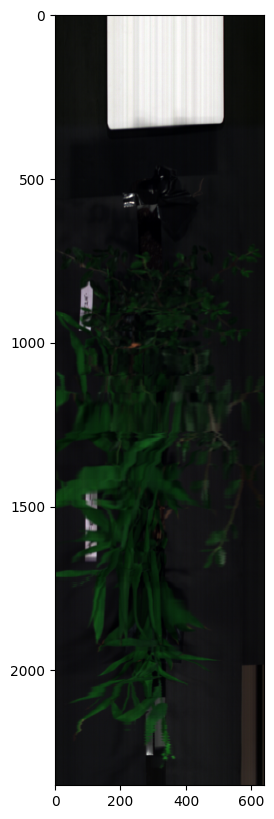

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
plt.imshow(img)
plt.show()

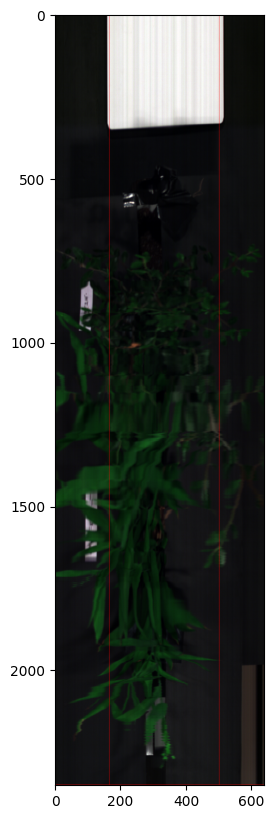

In [10]:
# crop lines:
# <<<=============================== Modify the crop range to match your image. ===============================>>>>
crop_rows = [0,2351]  # 2352 Total
crop_cols = [165,500]   # 640 Total

# Original Code Values
#crop_rows = [120,3000] 
#crop_cols = [100,500] 
# <<<==========================================================================================================>>>>

# creatre a red box on the image to show the crop area
for c in crop_cols:
    img[:,c,0] = 1.0
    img[:,c,1] = 0
    img[:,c,2] = 0
for r in crop_rows:
    img[r,:,0] = 1.0
    img[r,:,1] = 0
    img[r,:,2] = 0
# show the image with crop lines
plt.figure(figsize=(10,10)) 
plt.imshow(img)
plt.show()

# Part 3. Extract the white reference area (to use to convert the image to reflectance)

<span style="color: red">You will need to modify the rows for your white reference in your iamge to match your image.</span>

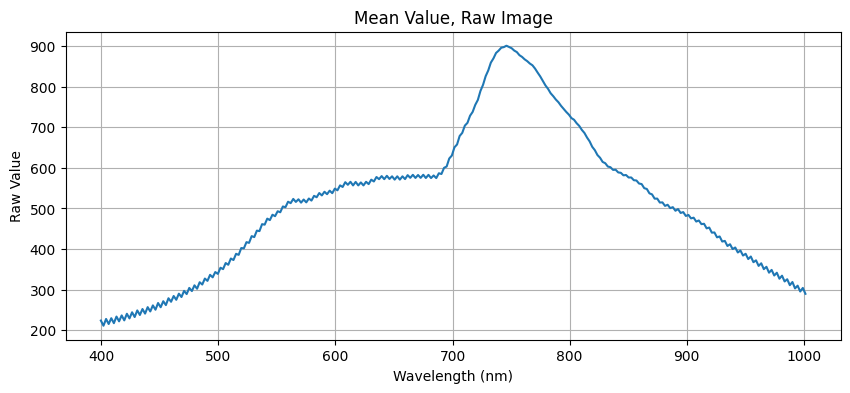

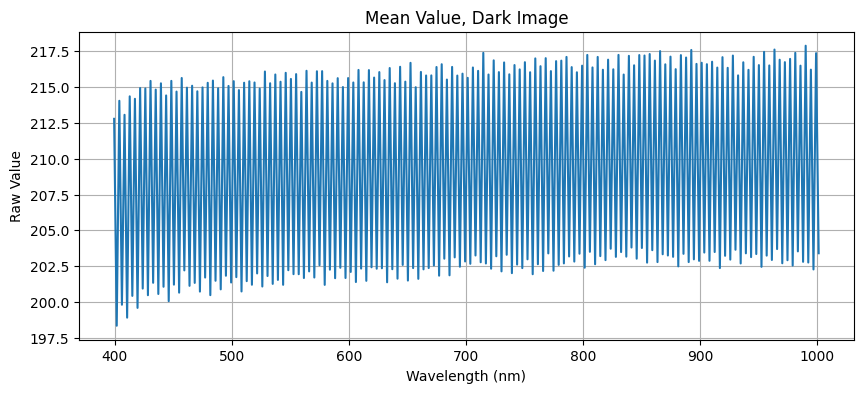

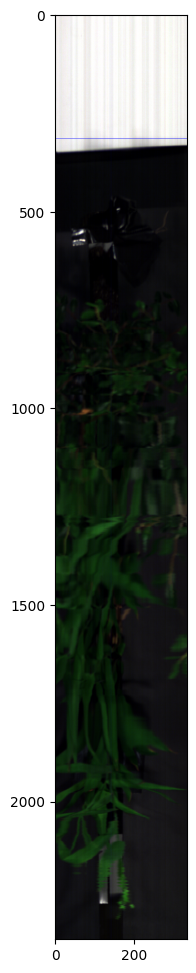

Origonial shape of im_igm.Arr = (2352, 640, 272)
Shape of im_igm.Arr after croppping = (2351, 335, 272)


In [11]:
# crop the hyperspectral image based on your drop ranges above
importlib.reload(msf)
# <<<=============================== Modify the rows for your white reference in your image to match your image. ===============================>>>>
white_ref_rows = [0, 314]
#white_ref_cols = [165,500]   

# <<<===========================================================================================================================================>>>>


# Open the image and read into an array
im = spectral.envi.open(fname_im_hdr, fname_im)
im.wl = np.asarray(im.bands.centers)
wl = im.wl
im.Arr = im.load()

# plot the mean raw measured value
image_mean = np.mean(np.mean(im.Arr, axis=0), axis=0)
plt.figure(figsize=(10,4))
plt.plot(im.wl, image_mean)
plt.title('Mean Value, Raw Image')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Raw Value')
plt.grid(True)
plt.show()


# Open the dark image and read into an array
im_dark = spectral.envi.open(fname_dark_hdr, fname_dark)
im_dark.wl = np.asarray(im_dark.bands.centers)
im_dark.Arr = im_dark.load()

# plot the mean raw measured dark value
image_dark_mean = np.mean(np.mean(im_dark.Arr, axis=0), axis=0)
plt.figure(figsize=(10,4))
plt.plot(im.wl, image_dark_mean)
plt.title('Mean Value, Dark Image')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Raw Value')
plt.grid(True)
plt.show()


# crop the image
imArr_cropped = im.Arr[crop_rows[0]:crop_rows[1], crop_cols[0]:crop_cols[1], :]
im.nr, im.nc, im.nb =imArr_cropped.shape

# Create the RGB with blue lines bounding the white refernce area
im_RGB = msf.make_rgb(imArr_cropped, im.wl)
for r in white_ref_rows:
    im_RGB[r,:,0] = 0
    im_RGB[r,:,1] = 0
    im_RGB[r,:,2] = 1.0
    
plt.figure(figsize=(12, 12)) 
plt.imshow(im_RGB)
plt.show()

print(f'Origonial shape of im_igm.Arr = {im.Arr.shape}')
print(f'Shape of im_igm.Arr after croppping = {imArr_cropped.shape}')

# The raw data is how much electric current was generated in each band over the entire image. 

# Y- How much light is hitting at each wavelenght
# Doesn't output as much light in the lower and higher edjes 
# Raw dark image (the electric current)

In [12]:
#importlib.reload(hva)
#hva.viewer(im.Arr, im.wl)

Spectra from White Reference, Raw Image (copy-paste from hsi_viewer)

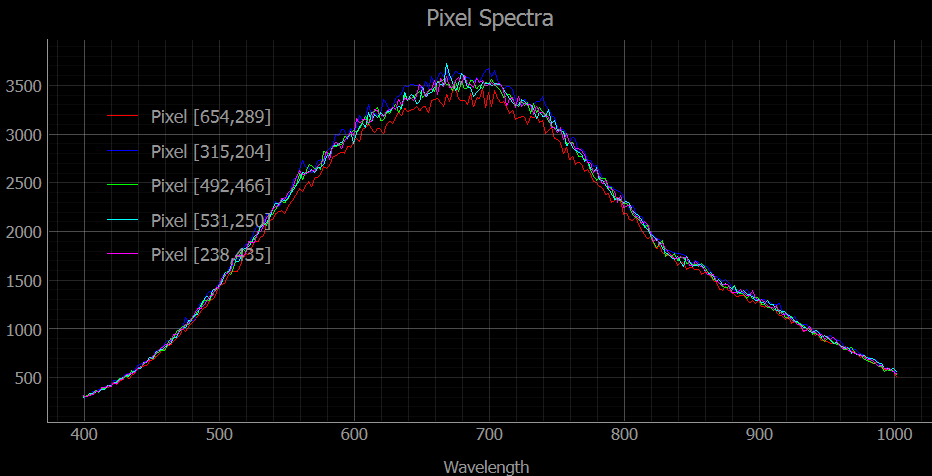

Spectral from healthy veg, raw image (copy-paste from hsi_viewer)

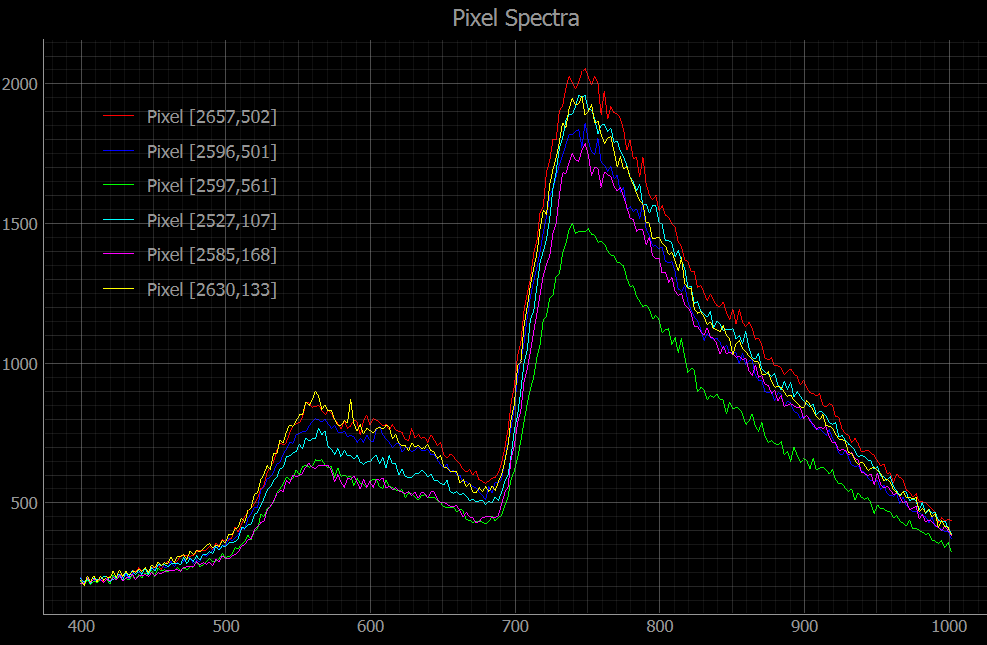

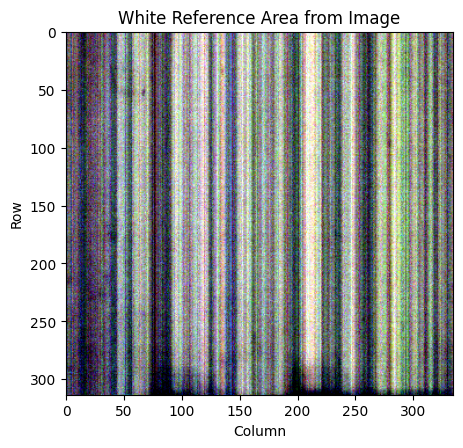

In [13]:
# create the white reference region from the inage
im_wr = imArr_cropped[white_ref_rows[0]:white_ref_rows[1], :, :]
#im_wr = im.Arr[white_ref_rows[0]:white_ref_rows[1],white_ref_cols[0]:white_ref_cols[1],:]
#im_wr[:,20,:] = 10000 # use these to check the arrangement of the columns and bands in the plots
#im_wr[:,:,100] = 10000 # use these to check the arrangement of the columns and bands in the plots
im_wr_RGB = msf.make_rgb(im_wr, im.wl)    
plt.figure(figsize=(5,5)) 
plt.imshow(im_wr_RGB)
plt.title('White Reference Area from Image')
plt.xlabel('Column')
plt.ylabel('Row')
plt.show()

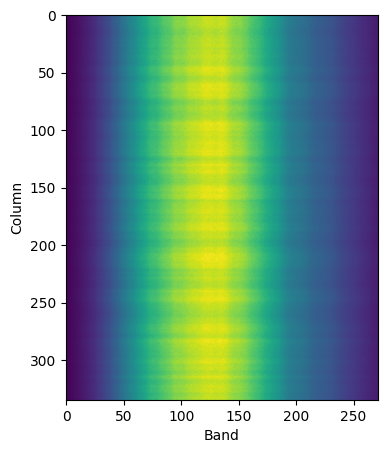

In [14]:
# image of Focal Plane Array (every pixel represents one detector)
im_FPA = np.mean(im_wr, axis=0)
plt.figure(figsize=(5,5)) 
plt.imshow(im_FPA)
plt.xlabel('Band')
plt.ylabel('Column')
plt.show()

In [15]:
# convert to reflectance
im_ref = np.zeros((im.nr, im.nc, im.nb))
for c in range(im.nc):
    for b in range(im.nb):
        im_ref[:,c,b] = np.squeeze(    (imArr_cropped[:,c,b]-image_dark_mean[b])   /   (im_FPA[c,b]-image_dark_mean[b])    ) # For every detector in the chess board

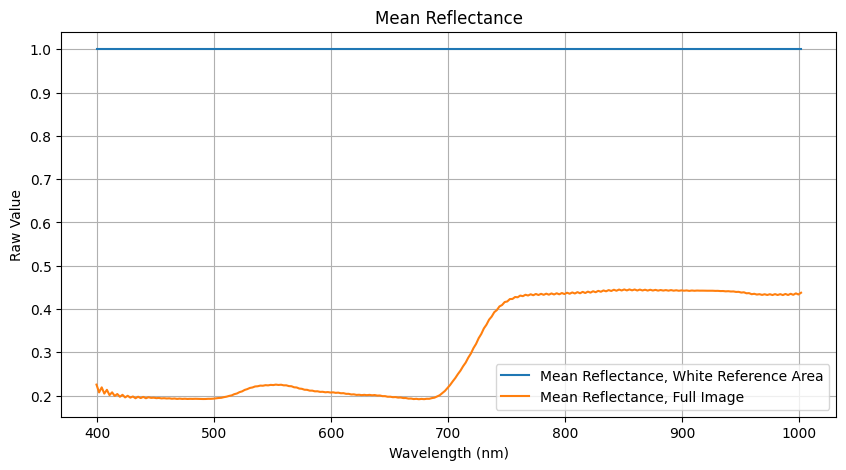

In [16]:
# plot the mean reflectance
# compute mean refleactance of white reference area
im_ref_wr = im_ref[white_ref_rows[0]:white_ref_rows[1], :, :]
im_ref_wr_mean = np.mean(np.mean(im_ref_wr, axis=0), axis=0)

# compute mean reflectance of full image
im_ref_mean = np.mean(np.mean(im_ref, axis=0), axis=0)
plt.figure(figsize=(10,5))
plt.plot(wl, im_ref_wr_mean, label='Mean Reflectance, White Reference Area')
plt.plot(wl, im_ref_mean, label='Mean Reflectance, Full Image')
plt.title('Mean Reflectance')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Raw Value')
plt.legend()
plt.grid(True)
plt.show()

In [17]:
#importlib.reload(hva)
#hva.viewer(im_ref, im.wl)

# How much noise is in the system

Pixels on White Reference: (copy-paste from hsi_viewer)

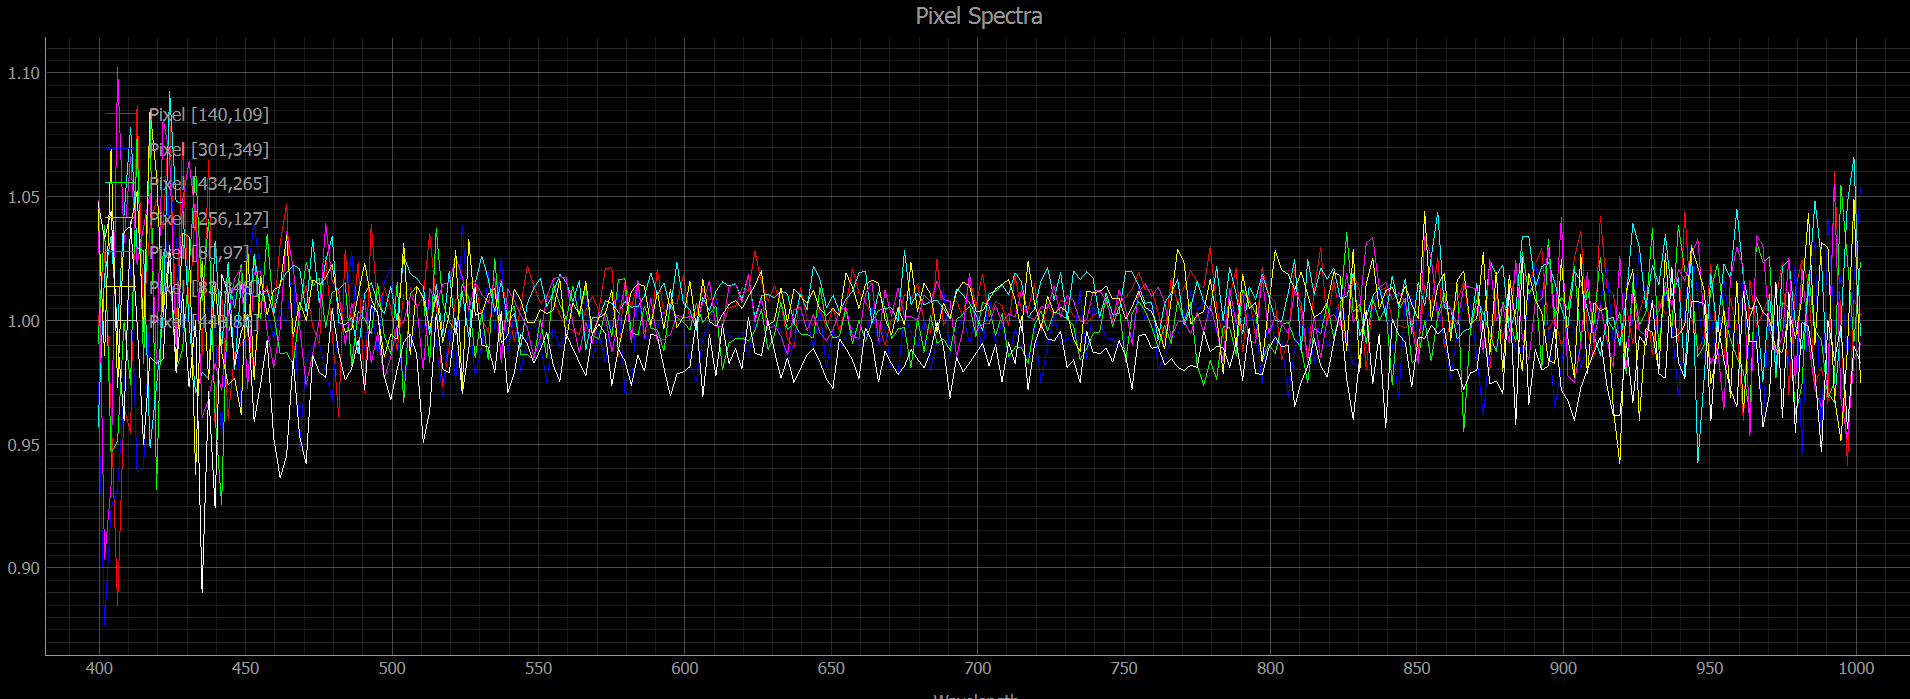

Pixels on healthy veg: (copy-paste from hsi_viewer)

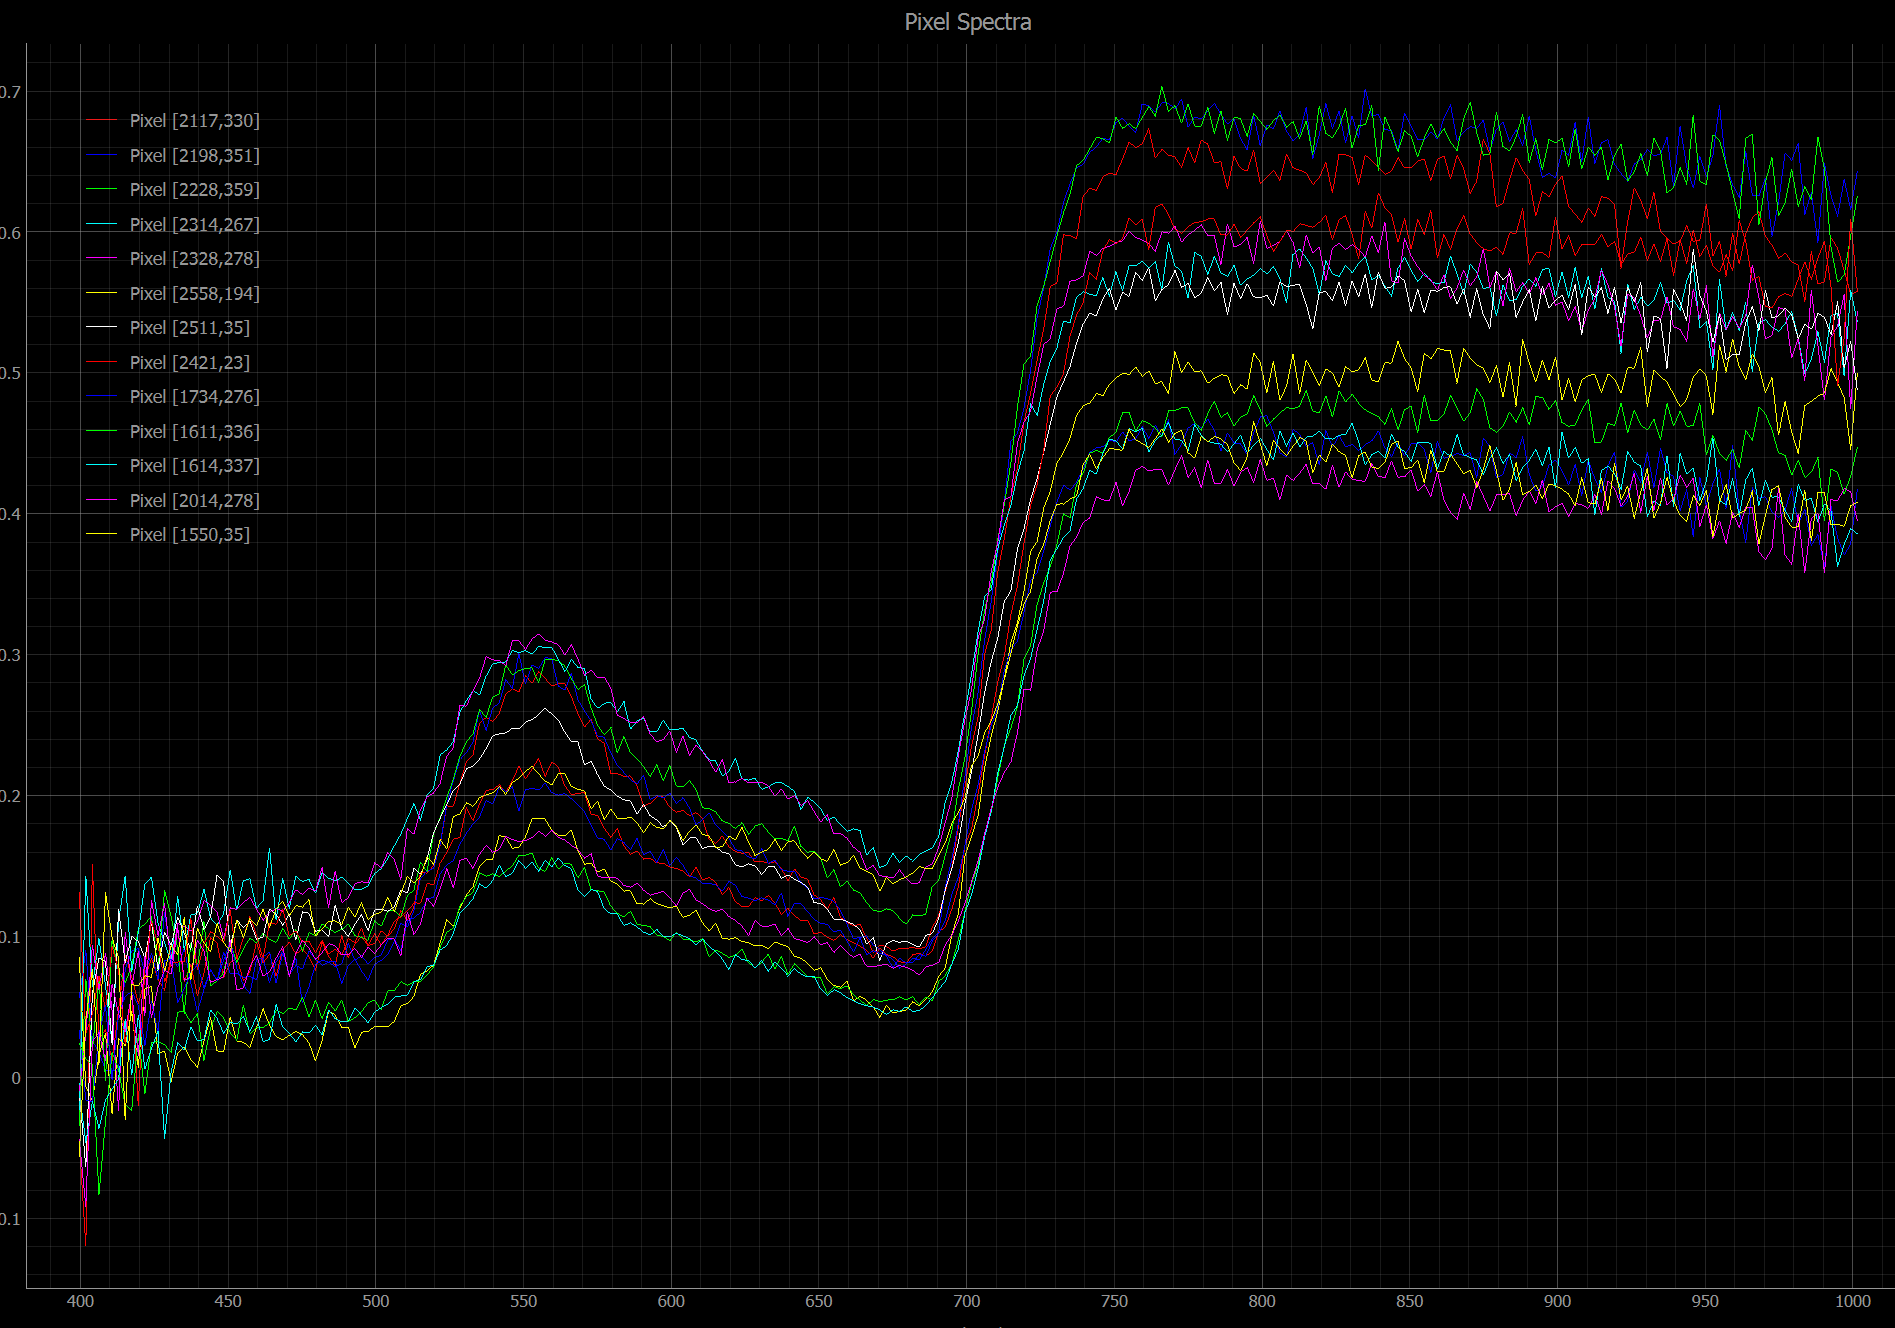

# Part 6. Save reflectance image

Question for Bill:

- Is this how the reflectance image should look like? If not, what could be possibly causing this? I'm not sure how to proceed from here.


- Why are we collecting the image to reflactance image in the first place? 

In [18]:
metadata = im.metadata
metadata['lines'] = im_ref.shape[0]
metadata['samples'] = im_ref.shape[1]
# create the structure for the reflectance image
spectral.envi.save_image(fname_im+'_ref'+'.hdr',im_ref.astype('float32'),
    metadata=metadata,
    ext='',
    force=True) 
print(fname_im+'_ref'+'.hdr')

C:\Users\luzya\OneDrive\Escritorio\PhD program\Spring 2025\Dr. Basener\100083_Allied_2_14_2025__dark_2015_06_04_20_53_05\100086_Allied_2_14_2025__2015_06_04_21_02_07\raw_0_ref.hdr


In [19]:
# delete variables to save memory
del im_ref

In [94]:
import spectral.io.envi as envi
import spectral
import matplotlib.pyplot as plt
import numpy as np

# Load the saved hyperspectral image
hdr_filename = fname_im + '_ref' + '.hdr'
im = envi.open(hdr_filename)
im.wl = np.asarray(im.bands.centers)

# Convert image to a NumPy array
im.Arr = im.load()

print(f'Shape of Im.Arr = {im.Arr.shape}')
im.List = np.reshape(im.Arr, (im.nrows*im.ncols, im.nbands))
print(f'Shape of im.List = {im.List.shape}')
dataList = im.List[np.sum(im.List, axis=1)>0, :]
print(f'Shape of dataList = {dataList.shape}')
nr = im.nrows
nc = im.ncols
nb = im.nbands


Shape of Im.Arr = (2351, 335, 272)
Shape of im.List = (787585, 272)
Shape of dataList = (787578, 272)


red index = 108, with wavelength = 639.4575566097759
green index = 68, with wavelength = 550.6238145587811
blue index = 27, with wavelength = 459.5692289565114


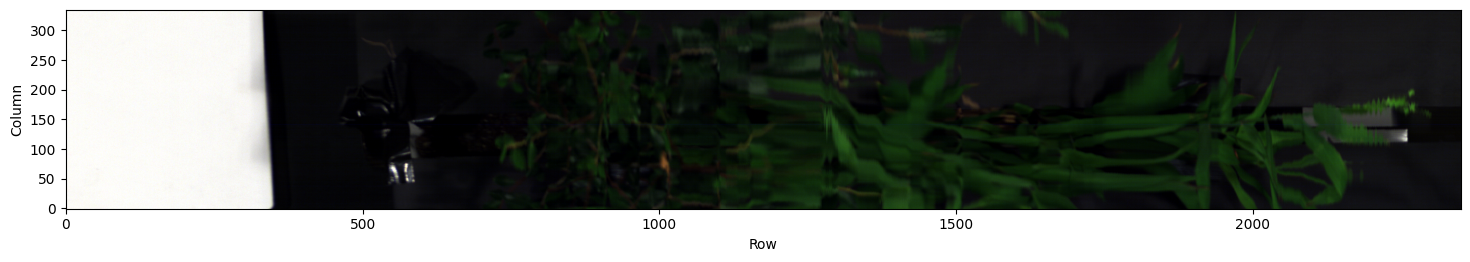

In [21]:
# determine the indices for the red, green, and blue bands
red_band_idx = np.argmin(np.abs(im.wl-640))
green_band_idx = np.argmin(np.abs(im.wl-550))
blue_band_idx = np.argmin(np.abs(im.wl-460))

print(f'red index = {red_band_idx}, with wavelength = {im.wl[red_band_idx]}')
print(f'green index = {green_band_idx}, with wavelength = {im.wl[green_band_idx]}')
print(f'blue index = {blue_band_idx}, with wavelength = {im.wl[blue_band_idx]}')

# Clip the bands
imRGB_clipped = im.Arr[:,:,[red_band_idx, green_band_idx, blue_band_idx]]
for i in range(3):
    # Create a variable to hold a single band from the image. 
    # This is not the most computationally efficient method, but simplifies the code.
    single_band = imRGB_clipped[:,:,i]
    # Clip the band
    lower_thresh = np.percentile(single_band.flatten(), 2)
    single_band[single_band < lower_thresh] = lower_thresh
    upper_thresh = np.percentile(single_band.flatten(), 98)
    single_band[single_band > upper_thresh] = upper_thresh
    # Rescale to [0,1].
    single_band = single_band - lower_thresh
    single_band = single_band / np.max(single_band)
    # Put the values for this band back into the RGB image.
    imRGB_clipped[:,:,i] = single_band

# plot the arraay
plt.figure(figsize=(18,8)) 
plt.imshow(np.flip(np.rot90(imRGB_clipped), axis=0));
plt.gca().invert_yaxis()  
plt.xlabel('Row');
plt.ylabel('Column');

In [22]:
imRGB_to_save = np.flip(np.rot90(imRGB_clipped), axis=0)

# Now save it as a PNG:
plt.imsave(main_dir+'100083_Allied_2_14_2025__dark_2015_06_04_20_53_05_ref.png', imRGB_to_save)

# STEP 3: Buils ROIs for the plants in the microscene image(s)

In [23]:
# load the Cooke City hyperspectral iamge
fname = 'C:\\Users\\luzya\OneDrive\\Escritorio\\PhD program\\Spring 2025\\Dr. Basener\\100083_Allied_2_14_2025__dark_2015_06_04_20_53_05\\100086_Allied_2_14_2025__2015_06_04_21_02_07\\raw_0_ref'
fname_hdr = 'C:\\Users\\luzya\\OneDrive\\Escritorio\\PhD program\\Spring 2025\\Dr. Basener\\100083_Allied_2_14_2025__dark_2015_06_04_20_53_05\\100086_Allied_2_14_2025__2015_06_04_21_02_07\\raw_0_ref.hdr'

# Open the image and read into an array
im = spectral.envi.open(fname_hdr, fname)
im.wl = np.asarray(im.bands.centers)
# Load the image into memory
im.Arr = im.load()
imArr = im.Arr
print(f'Shape of ImArr = {imArr.shape}')
imList = np.reshape(imArr, (im.nrows*im.ncols, im.nbands))
print(f'Shape of imList = {imList.shape}')

Shape of ImArr = (2351, 335, 272)
Shape of imList = (787585, 272)


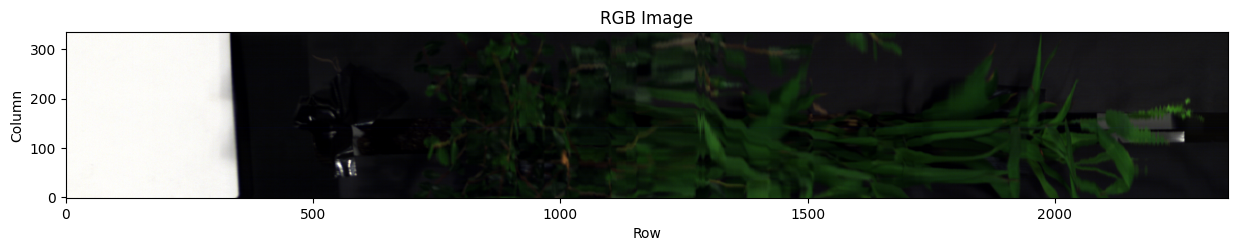

In [24]:
# display the image
sm2.display_RGB(imArr, im.wl, rotate=True)
plt.title('RGB Image');

In [32]:
from hsiViewer import hsi_viewer_ROI as hvr
importlib.reload(hvr)
hvr.viewer(im, stretch=[2,95], rotate=True)

632
[0. 1.]
229
[0. 1. 2.]
2840
[0. 1. 2. 3.]
430
[0. 1. 2. 3. 4.]
Class 0, mean=[0.08330658 0.04423023 0.06642704 0.04482162]
Class 1, mean=[0.0660547  0.03751482 0.07054578 0.03535484]
Class 2, mean=[0.1086118  0.07690973 0.09099863 0.08208723]
Class 3, mean=[0.11737105 0.09970513 0.13862541 0.10662684]
Class 0, color=[250, 50, 50]
Class 1, color=[90, 230, 232]
Class 2, color=[25, 36, 255]
Class 3, color=[255, 33, 237]
None
ROI file saved, D:/UPWINS_Microscene-main/from_Luz/100083_Allied_2_14_2025__dark_2015_06_04_20_53_05_ref_ROI.pkl


## Initial Evaluation of ROIs

# Step 4: Extract spectra from these regions to a spectral library file.

In [33]:
import pickle
fname = 'D:\\UPWINS_Microscene-main\\from_Luz\\spectral_data\\spectral_images\\100083_Allied_2_14_2025__dark_2015_06_04_20_53_05_ref_ROI.pkl'
with open(fname, 'rb') as f:
    roiData = pickle.load(f)

In [52]:
df = roiData.df # a DataFrame holding all the data for the ROIs
roi_names = roiData.names # the names of the ROIs
roi_colors = roiData.colors # a Python dictionary of colors, where colors[class_name] will provide the color for class class_name
roi_masks = roiData.masks # a Python dictionary of location masks, where colors[class_name] will provide the numpy array for the mask
nClasses = len(roi_names)

# Notes:
#   Each mask is an array of bollean values of the same dimensions as the image, 
#   and True represents a pixel in the ROI while False represents not in the ROI.

In [53]:
roi_names

['Iva_fru_L', 'Iva_fru_ST', 'Chas_lat_L', 'Chas_lat_SE']

In [54]:
roi_colors

{'Iva_fru_L': '#fa3232',
 'Iva_fru_ST': '#5ae6e8',
 'Chas_lat_L': '#1924ff',
 'Chas_lat_SE': '#ff21ed'}

In [55]:
roi_masks

{'Iva_fru_L': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]),
 'Iva_fru_ST': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]),
 'Chas_lat_L': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
    

In [56]:
nClasses

4

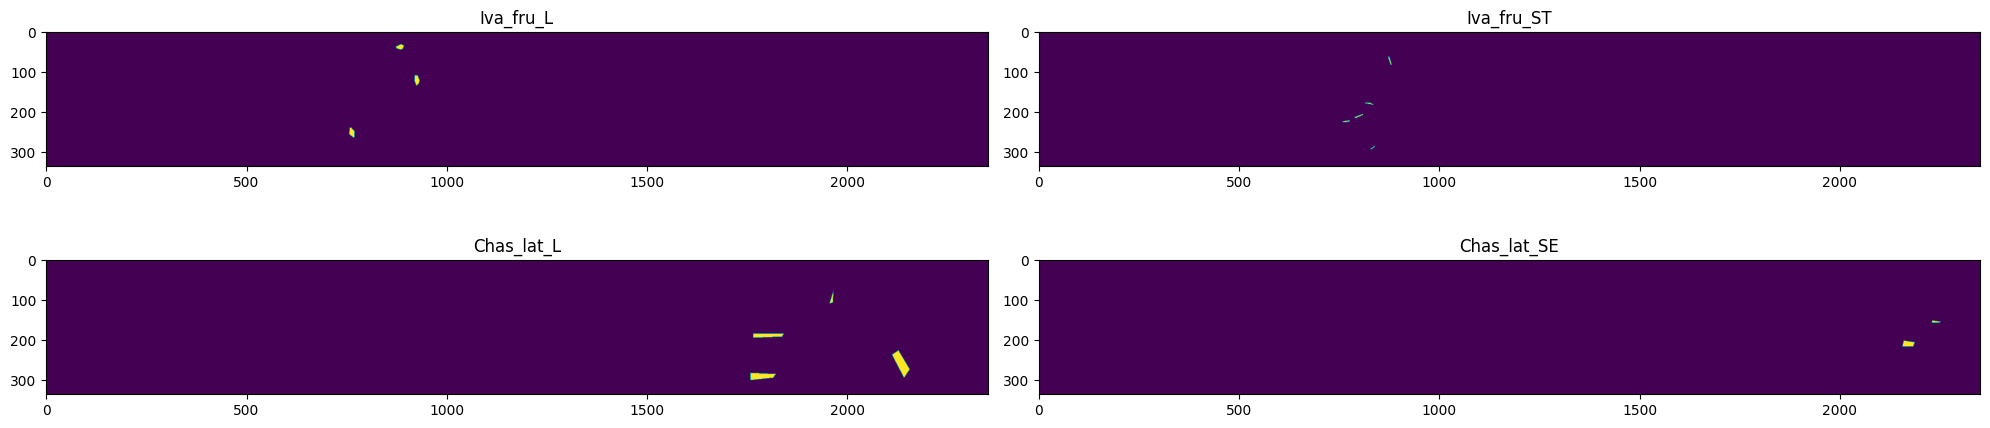

In [50]:
fig, axes = plt.subplots(2, 2, figsize=(20, 5))
axes = axes.flatten()

for ax, name in zip(axes, roiData.names):
    rotated_image = np.rot90(roiData.masks[name])
    ax.imshow(rotated_image)
    ax.set_title(name)

plt.tight_layout()
plt.show()

In [58]:
df

Name    Color  Pixel_x  Pixel_y  399.6064530720899  \
0      Iva_fru_L  #fa3232      766       71           0.003130   
1      Iva_fru_L  #fa3232      767       71          -0.054694   
2      Iva_fru_L  #fa3232      768       71          -0.011326   
3      Iva_fru_L  #fa3232      765       72           0.045771   
4      Iva_fru_L  #fa3232      766       72           0.145381   
..           ...      ...      ...      ...                ...   
425  Chas_lat_SE  #ff21ed     2232      181           0.151653   
426  Chas_lat_SE  #ff21ed     2233      181           0.043489   
427  Chas_lat_SE  #ff21ed     2234      181           0.246296   
428  Chas_lat_SE  #ff21ed     2235      181           0.111091   
429  Chas_lat_SE  #ff21ed     2229      182           0.107922   

     401.8272966233649  404.0481401746397  406.2689837259146  \
0            -0.004037           0.043716          -0.044950   
1             0.066995           0.121075           0.011165   
2             0.102512           0.021614           0.011165   
3             0.066584           0.114122           0.123772   
4             0.019520           0.103706           0.123772   
..                 ...                ...                ...   
425           0.233761           0.138550           0.103358   
426           0.091071           0.127856           0.057190   
427           0.031617           0.159938           0.195692   
428           0.126744           0.085080           0.158758   
429           0.126553           0.214657           0.106693   

     408.4898272771894  410.7106708284643  ...  981.4674635061059  \
0             0.044618           0.085665  ...           0.712219   
1             0.035577           0.070223  ...           0.687623   
2             0.035577           0.070223  ...           0.671226   
3             0.080946           0.000751  ...           0.693592   
4             0.108125           0.064249  ...           0.715300   
..                 ...                ...  ...                ...   
425           0.099676          -0.016780  ...           0.717112   
426           0.082972          -0.016780  ...           0.690415   
427           0.158137           0.141745  ...           0.701094   
428           0.066269           0.000834  ...           0.767837   
429           0.128247           0.166205  ...           0.776565   

     983.6883070573808  985.9091506086556  988.1299941599306  \
0             0.666026           0.687614           0.636054   
1             0.718432           0.710972           0.713623   
2             0.685333           0.664256           0.716606   
3             0.756876           0.692880           0.714197   
4             0.720764           0.727888           0.778804   
..                 ...                ...                ...   
425           0.672575           0.764862           0.713697   
426           0.647085           0.735945           0.675070   
427           0.709395           0.701245           0.707754   
428           0.751879           0.718595           0.743410   
429           0.775299           0.730490           0.763513   

     990.3508377112054  992.5716812624803  994.7925248137551  997.01336836503  \
0             0.712863           0.724314           0.710077         0.701563   
1             0.675688           0.714580           0.696473         0.708553   
2             0.681884           0.669158           0.604645         0.670107   
3             0.683767           0.701300           0.710292         0.660590   
4             0.737554           0.753430           0.710292         0.699297   
..                 ...                ...                ...              ...   
425           0.671287           0.686096           0.679638         0.700930   
426           0.721923           0.695840           0.703215         0.659235   
427           0.680781           0.695840           0.723424         0.707880   
428           0.702934           0.741310 

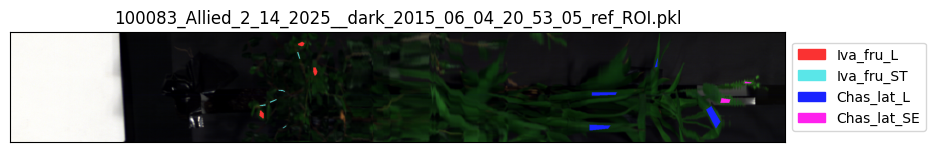

In [63]:
# create an RGB image
RGB_image_with_ROIs = msf.make_rgb(im.Arr, wl, stretch=[2, 98])

# Add the ROI locations
for name in roi_names:
    # get the color for this ROI, converted from hex to (r,g,b)
    color = colors.to_rgb(roi_colors[name])
    mask = roi_masks[name]
    # set the pixel values for this ROI to (0,0,0)
    for i in range(3):
        RGB_image_with_ROIs[:,:,i] = RGB_image_with_ROIs[:,:,i] * (mask == False)
    # set the pixel values for this ROI to the color for this ROI
    for i in range(3):
        RGB_image_with_ROIs[:,:,i] = RGB_image_with_ROIs[:,:,i] + mask * color[i]

# Rotate the image 90 degrees counterclockwise
rotated_RGB = np.rot90(RGB_image_with_ROIs)

# Plot the rotated image
plt.figure(figsize=(10,10))
plt.imshow(rotated_RGB)
plt.xticks([])
plt.yticks([])
plt.title(os.path.basename(fname))

# Create legend patches: each patch is a colored box with the ROI name.
legend_patches = [mpatches.Patch(color=roi_colors[name], label=name) for name in roi_names]
# Add the legend to the right of the image
plt.legend(handles=legend_patches, loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [82]:
spectra = df.to_numpy()[:,4:] # an array that holds all the spectra (each row is a spectrum)
spectra = spectra.astype(np.float32)
spectra_names = df['Name'].to_numpy()
nSpec = spectra.shape[0]

In [83]:
spectra

array([[ 0.00312984, -0.00403744,  0.04371625, ...,  0.7015625 ,
         0.6485249 ,  0.7094376 ],
       [-0.05469444,  0.06699546,  0.12107488, ...,  0.7085526 ,
         0.6933455 ,  0.76994437],
       [-0.01132623,  0.10251192,  0.02161378, ...,  0.67010707,
         0.6298497 ,  0.6602759 ],
       ...,
       [ 0.24629644,  0.0316173 ,  0.1599379 , ...,  0.7078796 ,
         0.6827622 ,  0.6843327 ],
       [ 0.11109135,  0.12674391,  0.08507953, ...,  0.6627099 ,
         0.73397887,  0.69186944],
       [ 0.10792205,  0.12655304,  0.21465681, ...,  0.7495747 ,
         0.761152  ,  0.76034755]], dtype=float32)

In [84]:
spectra_names

array(['Iva_fru_L', 'Iva_fru_L', 'Iva_fru_L', ..., 'Chas_lat_SE',
       'Chas_lat_SE', 'Chas_lat_SE'], dtype=object)

In [85]:
nSpec

4131

## Visualization of Mean and all Individual Spectral for each Class

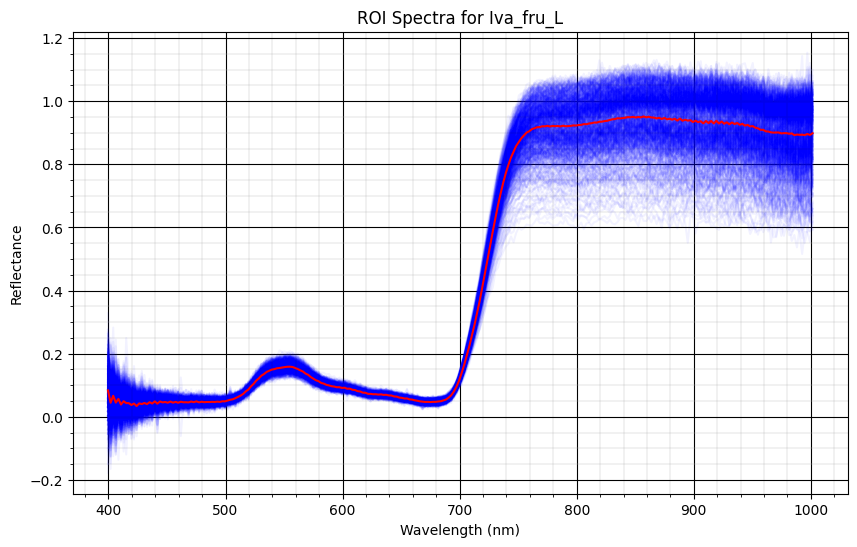

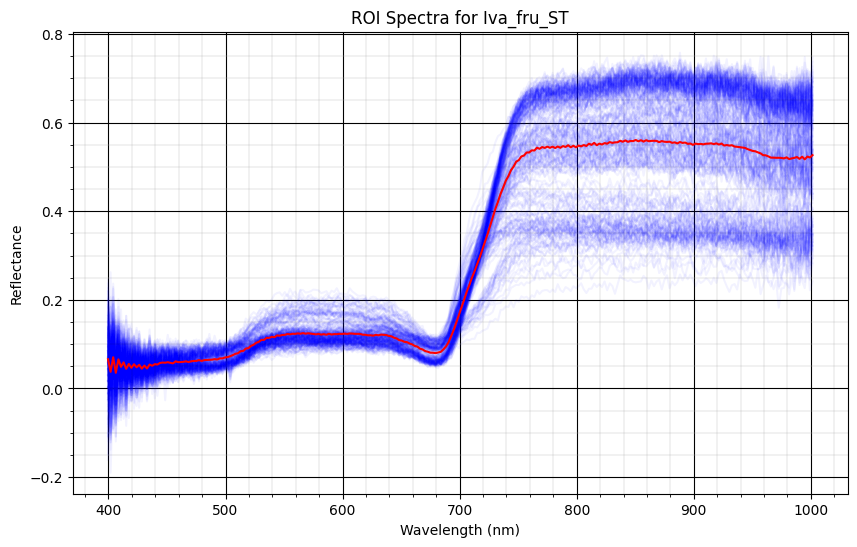

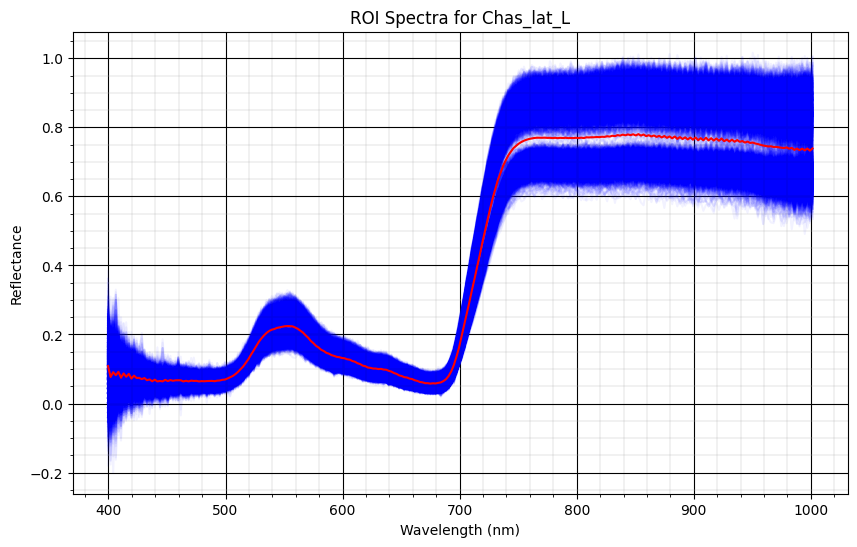

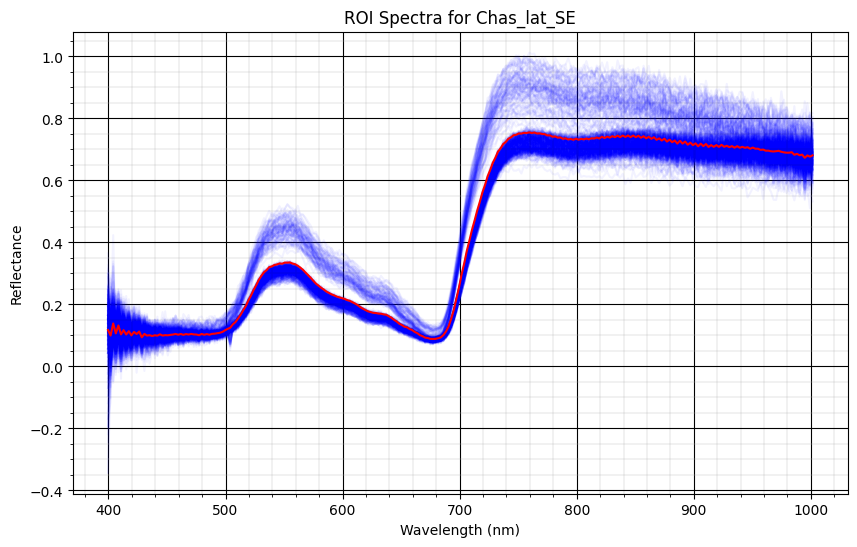

In [65]:
# plot the mean (red) and all individual spectra (blue) of each class
# we save the mean for each class for use later
means = {}
for name in roi_names:
    class_spectra = spectra[spectra_names==name,:]
    class_nSpec = class_spectra.shape[0]
    plt.figure(figsize=(10,6)) 
    for i in range(class_nSpec):
        plt.plot(wl,class_spectra[i,:].flatten(), color='b', alpha=0.05)
    means[name] = np.mean(class_spectra, axis=0)
    plt.plot(wl, means[name], color='r')
    plt.minorticks_on()
    plt.grid(True, which='major', c='k')
    plt.grid(True, which='minor', linewidth=0.25)
    plt.title(f'ROI Spectra for {name}')
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Reflectance')
    plt.grid(True)

## Visualization of Mean and all Individual Spectral for each Class

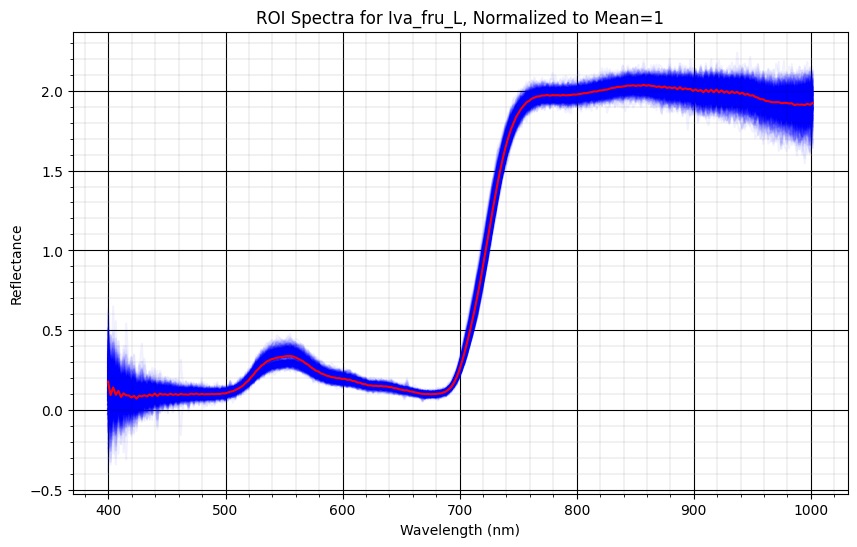

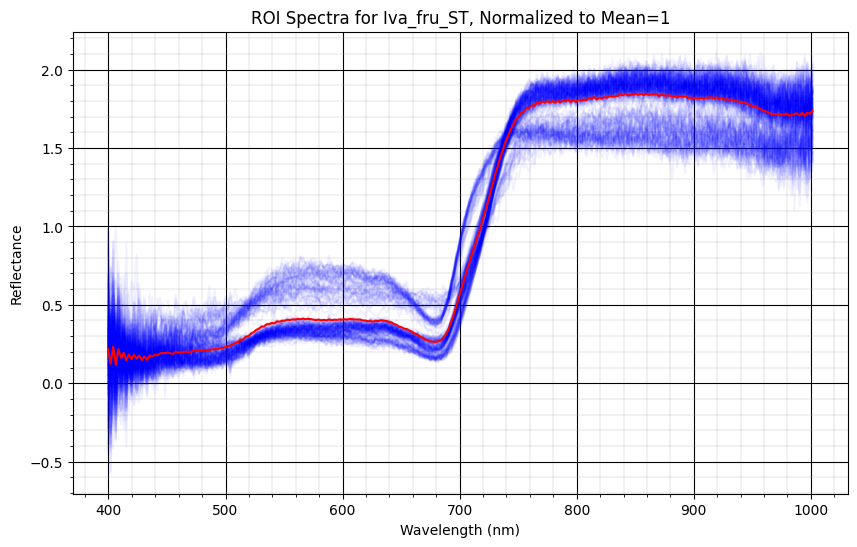

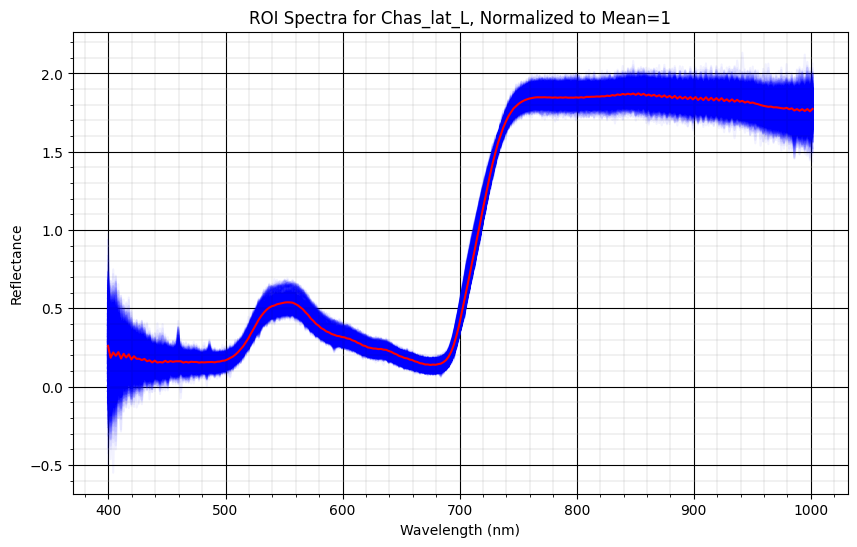

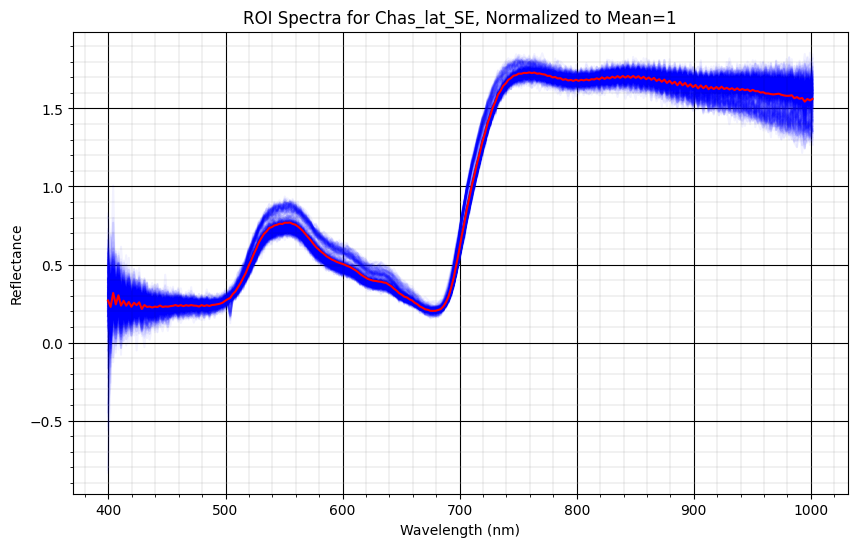

In [67]:
# Plot the mean (red) and all individual spectra (blue) of each class,
# scaling all spectra to have mean value of 1
for name in roi_names:
    class_spectra = spectra[spectra_names == name, :]
    class_nSpec = class_spectra.shape[0]
    plt.figure(figsize=(10,6))
    # Plot individual spectra in blue
    for i in range(class_nSpec):
        plt.plot(wl, class_spectra[i, :].flatten() / np.mean(class_spectra[i, :].flatten()),
                 color='b', alpha=0.05)
    plt.minorticks_on()
    plt.grid(True, which='major', c='k')
    plt.grid(True, which='minor', linewidth=0.25)
    # Plot mean spectrum in red
    plt.plot(wl, means[name] / np.mean(means[name]), color='r')
    plt.title(f'ROI Spectra for {name}, Normalized to Mean=1')
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Reflectance')
    plt.grid(True)
    plt.show()

## Plot All Means Together

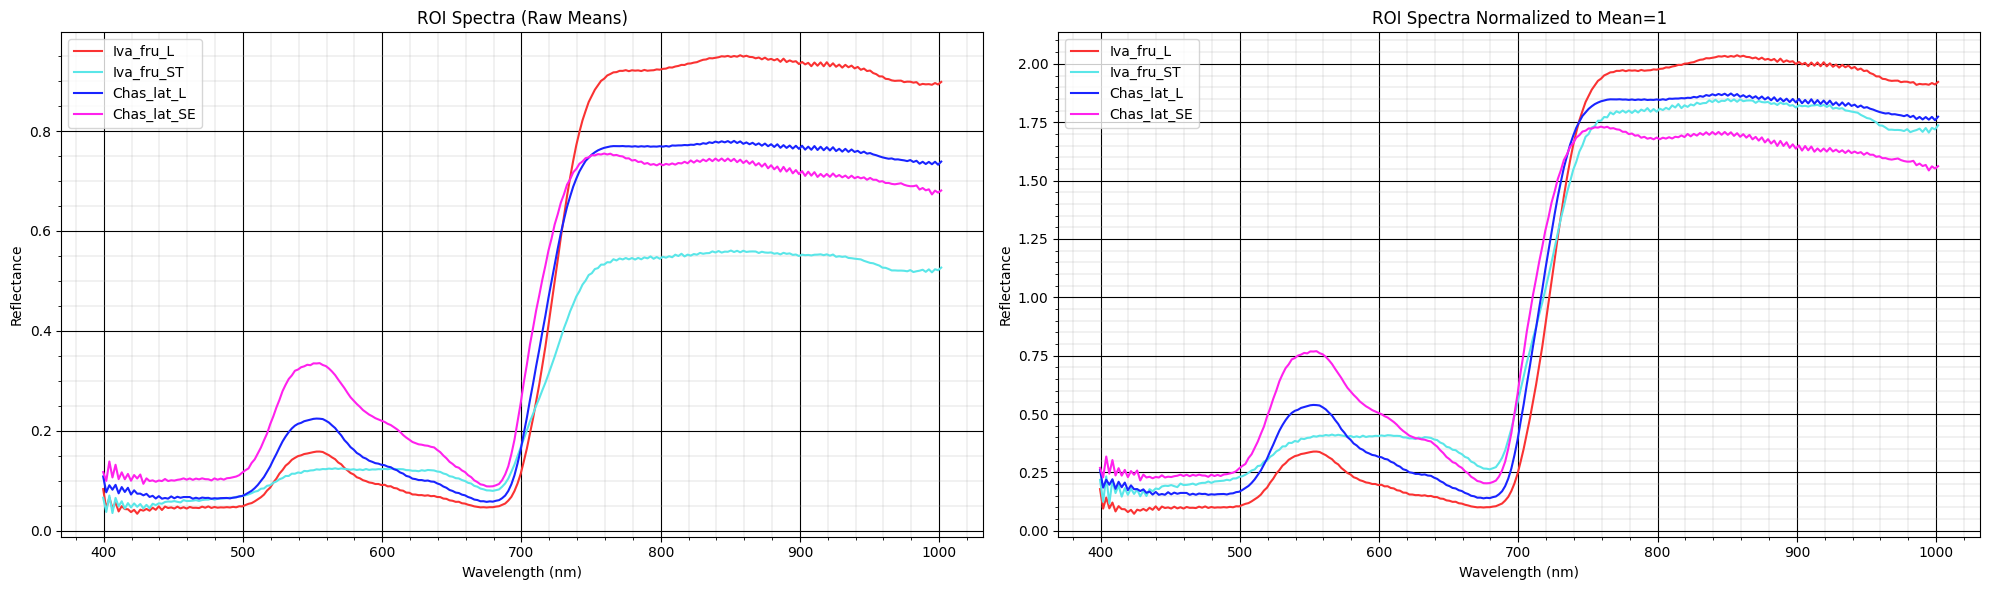

In [75]:
# Create a figure with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Left subplot: Plot raw mean spectra
for name in roi_names:
    axes[0].plot(wl, means[name], label=name, color=roi_colors[name])
axes[0].set_title('ROI Spectra (Raw Means)')
axes[0].minorticks_on()
axes[0].grid(True, which='major', c='k')
axes[0].grid(True, which='minor', linewidth=0.25)
axes[0].set_xlabel('Wavelength (nm)')
axes[0].set_ylabel('Reflectance')
axes[0].legend()

# Right subplot: Plot normalized mean spectra
for name in roi_names:
    axes[1].plot(wl, means[name] / np.mean(means[name]), label=name, color=roi_colors[name])
axes[1].set_title('ROI Spectra Normalized to Mean=1')
axes[1].minorticks_on()
axes[1].grid(True, which='major', c='k')
axes[1].grid(True, which='minor', linewidth=0.25)
axes[1].set_xlabel('Wavelength (nm)')
axes[1].set_ylabel('Reflectance')
axes[1].legend()

plt.tight_layout()
plt.show()

## Plot the class Means, then a scatterplot of each class on the same 2 bands

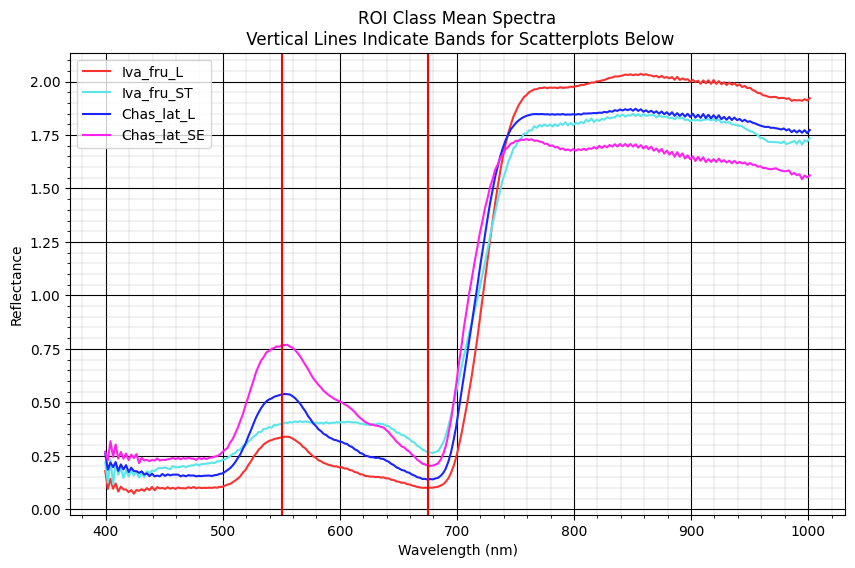

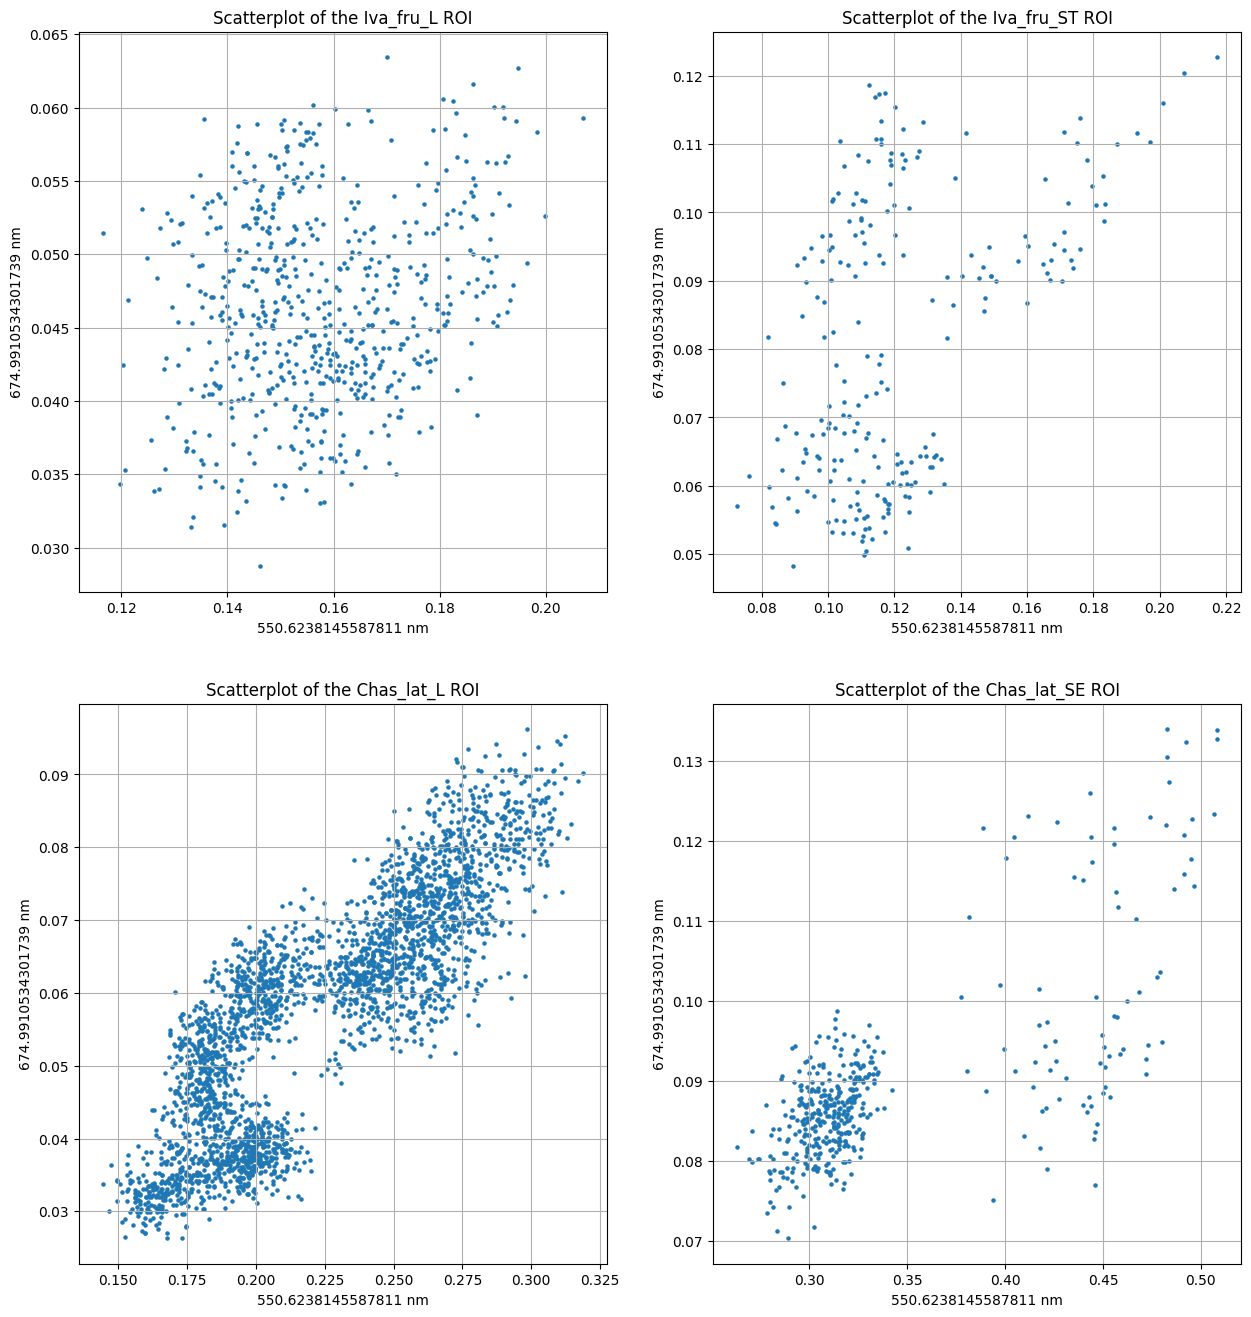

In [76]:
# Plot the class Means, then a scatterplot of each class on the same 2 bands
b1 = np.argmin(np.abs(wl-550))# index for band 1 for scatterplots
b2 = np.argmin(np.abs(wl-675))# index for band 2 for scatterplots

plt.figure(figsize=(10,6)) 
for name in roi_names:
    plt.plot(wl, means[name]/np.mean(means[name]), label=name, color=roi_colors[name])
plt.axvline(wl[b1], color='red')
plt.axvline(wl[b2], color='red')
plt.minorticks_on()
plt.grid(True, which='major', c='k')
plt.grid(True, which='minor', linewidth=0.25)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance')
plt.legend()
plt.title(f'ROI Class Mean Spectra\n Vertical Lines Indicate Bands for Scatterplots Below')
plt.legend()
plt.grid(True)

nPlotRows = int(np.ceil(len(roi_names)/2))
plt.figure(figsize=(15,int(8*nPlotRows)))
i = 0
for name in roi_names:
    plt.subplot(nPlotRows, 2, i+1)  
    plt.title(f'Scatterplot of the {name} ROI')
    class_spectra = spectra[spectra_names==name,:]
    plt.scatter(class_spectra[:,b1], class_spectra[:,b2], s=5)
    plt.xlabel(f'{wl[b1]} nm')
    plt.ylabel(f'{wl[b2]} nm')
    plt.grid(True);
    i = i + 1

## Viewing scatterplots of the ROI spectra

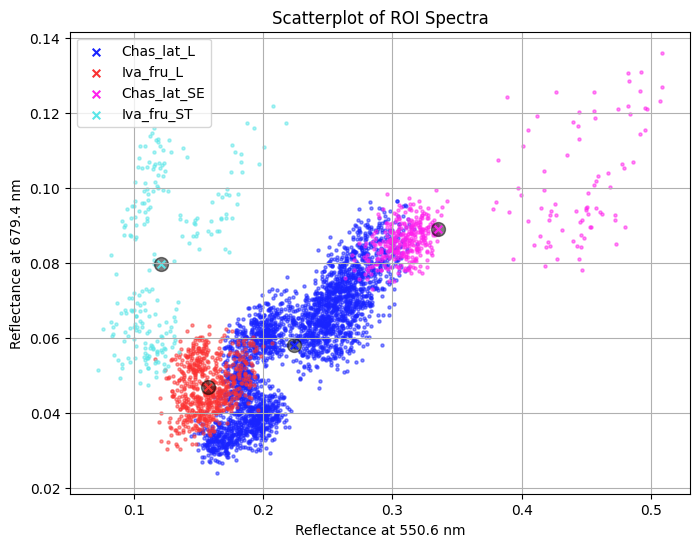

In [77]:
# Create a scatterplot of the data
i1 = np.argmin(np.abs(wl-550))
i2 =  np.argmin(np.abs(wl-680))

# sort by number of pixels in each ROI
pixCount = []
for name in roi_names:
    pixCount.append(np.sum(roi_masks[name]))
pixCount = np.asarray(pixCount)
idx_order = np.argsort(-pixCount)

plt.figure(figsize=(8,6))

# plot all of the spectra for this class
for i in idx_order:
    # get the ROI name
    name = roi_names[i]
    # get the indices for the spectra for this class
    class_spectra = spectra[spectra_names==name,:]    
    # scatterplot the class spectra at this band
    plt.scatter(class_spectra[:,i1], class_spectra[:,i2], s=5, color=roi_colors[name], alpha=0.5);
    
    
# plot the class mean spectrum for this class
for i in idx_order:
    # get the ROI name
    name = roi_names[i]
    # scatterplot the class mean spectrum at this band
    plt.scatter(means[name][i1], means[name][i2], s=100, color='k', alpha=0.5);
    plt.scatter(means[name][i1], means[name][i2], marker='x', s=30, label=name, color=roi_colors[name]);
    
plt.grid(True)
plt.legend()
plt.xlabel(f'Reflectance at {wl[i1]:.1f} nm')
plt.ylabel(f'Reflectance at {wl[i2]:.1f} nm')
plt.title('Scatterplot of ROI Spectra');

## Viewing PCA-transformed scatterplots of the ROI spectra

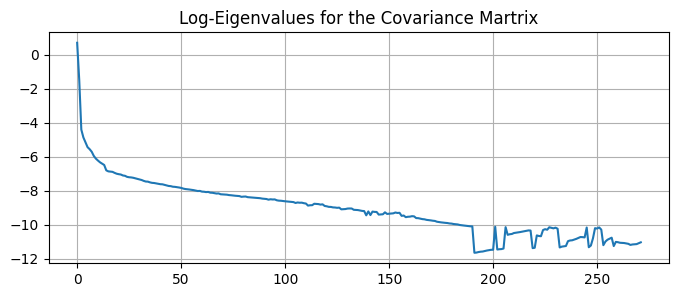

In [78]:
# compute mean and covariance of the spectra
mu = np.mean(spectra, axis=0)
C = np.cov(spectra.T)

# Compute the eigenvectors, eigenvalues, and whitening matrix
evals,evecs = np.linalg.eig(C)
# Plot the eigenvalues to examine stability 
# (Only the first N-1 of these will be meaningful, where N = # classes)
plt.figure(figsize=(8,3))
plt.plot(np.log(evals))
plt.grid(True)
plt.title('Log-Eigenvalues for the Covariance Martrix')
# truncate the small eigenvalues to stablize the inverse
tol = 10**(-8)
evals[evals<tol] = tol
DiagMatrix = np.diag(evals**(-1/2))
W = np.matmul(evecs,DiagMatrix)

# whiten the spectra
Wspectra = np.matmul(W.T, (spectra-mu).T).T

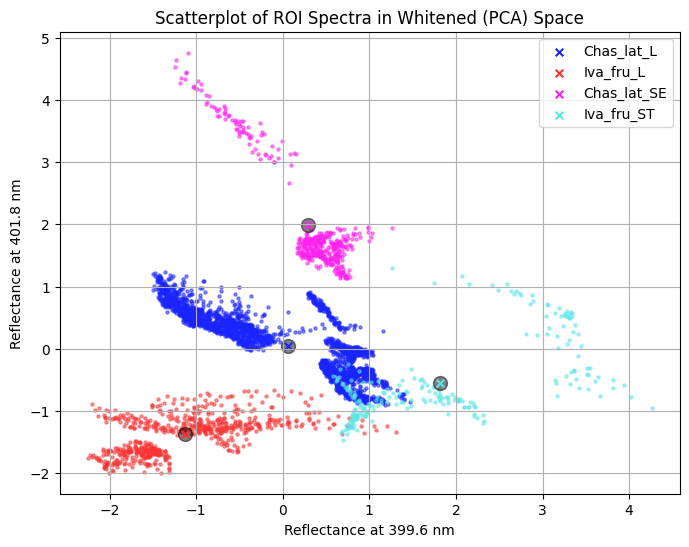

In [79]:
# Create a scatterplot of the data
i1 = 0
i2 = 1

# sort by number of pixels in each ROI
pixCount = []
for name in roi_names:
    pixCount.append(np.sum(roi_masks[name]))
pixCount = np.asarray(pixCount)
idx_order = np.argsort(-pixCount)

plt.figure(figsize=(8,6))

Wmeans = {}
# plot all of the spectra for this class
for i in idx_order:
    # get the ROI name
    name = roi_names[i]
    # get the indices for the spectra for this class
    class_spectra = Wspectra[spectra_names==name,:]   
    Wmeans[name] = np.mean(class_spectra, axis=0)
    # scatterplot the class spectra at this band
    plt.scatter(class_spectra[:,i1], class_spectra[:,i2], s=5, color=roi_colors[name], alpha=0.5);
    
    
# plot the class mean spectrum for this class
for i in idx_order:
    # get the ROI name
    name = roi_names[i]
    # scatterplot the class mean spectrum at this band
    plt.scatter(Wmeans[name][i1], Wmeans[name][i2], s=100, color='k', alpha=0.5);
    plt.scatter(Wmeans[name][i1], Wmeans[name][i2], marker='x', s=30, label=name, color=roi_colors[name]);
    
plt.grid(True)
plt.legend()
plt.xlabel(f'Reflectance at {wl[i1]:.1f} nm')
plt.ylabel(f'Reflectance at {wl[i2]:.1f} nm')
plt.title('Scatterplot of ROI Spectra in Whitened (PCA) Space');

**Observation:** There is often overlap between vegetation species (more generally between similar classes).

# Step 5: Build, train, test and save classification\detection models.

## Viewing LDA-transformed scatterplots of the ROI spectra

### LDA: https://en.wikipedia.org/wiki/Linear_discriminant_analysis
### PCA vs LDA: https://sebastianraschka.com/Articles/2014_python_lda.html

![PCS vs LDA](pcavslda.png)

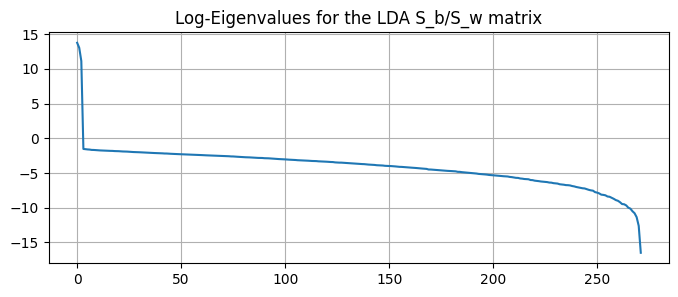

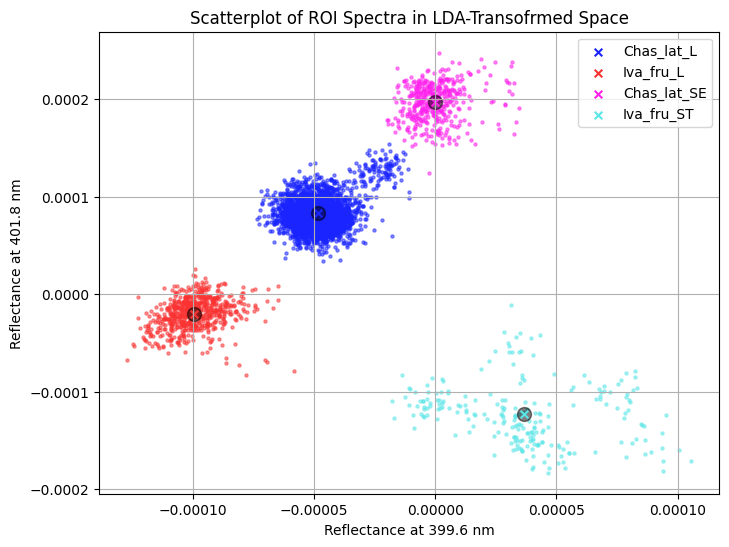

In [86]:
# ----- Compute the LDA Transform -----

# Compute the covaraince (often called the within-class-scatter in LDA, denoted S_W)
nClasses = len(roi_names)
nb = spectra.shape[1]
C = np.zeros((nb,nb)) # covariance (Sigma in the Wikipedia page)
for name in roi_names:
    # get the spectra for this class
    class_spectra = spectra[spectra_names==name,:]    
    # compute the covariance for this class
    C_class = np.cov(class_spectra.T)
    # compute the number of spectra in this class
    nSpec_class = class_spectra.shape[0]
    # add the covariance of this class,
    # weighted by the fraction of total pixels that come from this class
    C = C + (nSpec_class/nSpec)*C_class 
    
# Computing the coavariance of the means (often called the between-class scatter in LDA, denoted S_b)
Cb = np.zeros((nb,nb))
for name in roi_names:
    mu_diff = np.reshape((means[name] - mu), (nb,1))
    #Cb = Cb + (1/nClasses)*np.matmul(mu_diff, mu_diff.T) # <---- This formula is for balanced datasets
    nSpec_class = np.sum(spectra_names==name)
    Cb = Cb + (nSpec_class)*np.matmul(mu_diff, mu_diff.T) # <---- This formula is for imbalanced datasets

# Compute SVD of S_W^(-1) S_B
evecs, evals, Vt = svd(np.linalg.pinv(C).dot(Cb))
# Plot the eigenvalues to examine stability 
# (Only the first N-1 of these will be meaningful, where N = # classes)
plt.figure(figsize=(8,3))
plt.plot(np.log(evals))
plt.grid(True)
plt.title('Log-Eigenvalues for the LDA S_b/S_w matrix')
# truncate the small eigenvalues to stablize the inverse
tol = 10**(-8)
evals[evals<tol] = tol
DiagMatrix = np.diag(evals**(-1/2))
W_lda = np.matmul(evecs,DiagMatrix)

# LDA-transform the spectra
LDA_spectra = np.matmul(W_lda.T, (spectra).T).T



# ----- Plot the Transformed Data -----
# Create a scatterplot of the data
i1 = 0
i2 = 1
# sort by number of pixels in each ROI
pixCount = []
for name in roi_names:
    pixCount.append(np.sum(roi_masks[name]))
pixCount = np.asarray(pixCount)
idx_order = np.argsort(-pixCount)
# Create the scatterplot of the LDA-transformed data
plt.figure(figsize=(8,6))
LDA_means = {}
# plot all of the spectra for this class
for i in idx_order:
    # get the ROI name
    name = roi_names[i]
    # get the indices for the spectra for this class
    class_spectra = LDA_spectra[spectra_names==name,:]   
    LDA_means[name] = np.mean(class_spectra, axis=0)
    # scatterplot the class spectra at this band
    plt.scatter(class_spectra[:,i1], class_spectra[:,i2], s=5, color=roi_colors[name], alpha=0.5);
# plot the class mean spectrum for this class
for i in idx_order:
    # get the ROI name
    name = roi_names[i]
    # scatterplot the class mean spectrum at this band
    plt.scatter(LDA_means[name][i1], LDA_means[name][i2], s=100, color='k', alpha=0.5);
    plt.scatter(LDA_means[name][i1], LDA_means[name][i2], marker='x', s=30, label=name, color=roi_colors[name]);
plt.grid(True)
plt.legend()
plt.xlabel(f'Reflectance at {wl[i1]:.1f} nm')
plt.ylabel(f'Reflectance at {wl[i2]:.1f} nm')
plt.title('Scatterplot of ROI Spectra in LDA-Transofrmed Space');

## Computing Mahalanobis Distances

#### Why are we doing this?

Knowing these properties helps us simplify the Mahalanobis distance formula and understand the structure of the data better. It also tells us how to transform the data to improve classification accuracy.

#### Covariance Matrix
- **Off-diagonal terms**: These terms show the relationship (covariance) between different variables.
- **Zero covariance**: If the covariance between two variables is zero, it means there’s no linear relationship between them (linearly independent).
- **Diagonal values**: Represent the variance of each variable (that's how much each variable spreads around the mean).

#### Whitening (PCA)
- **Whitening matrix (`W`)**: W = PD^(-1/2)

Where `P` is a matrix of eigenvectors, and `D` is a diagonal matrix of eigenvalues. The columns of `W` are called **Principal Components**.

- **Gamma Inverse**: gamma^-1 = W * W^T

- **Transforming the Data**: Y = W^T * (X - mu)

where `X` is the original data, `mu` is the mean vector of the data, and `Y` is the new transformed data.

#### Mahalanobis Distance
- The usual Mahalanobis distance formula is: (x - mu) * Sigma^-1 * (x - mu)^T
- If we replace `Sigma` with `W * W^T`, we can rewrite it as: (W^T * (x - mu)) * (W^T * (x - mu))^T
- This makes the calculation easier when using the whitened data (`Y`).

#### Why is it Called Whitening?
- After applying the whitening transformation (`W`), if you compute the covariance of the transformed data, the diagonal entries will be equal to 1. This means the variance is equalized across all transformed variables, and the data is uncorrelated.

#### PCA
In our dataset, since we have 420 bands, we have 420 principal components.

- **Principal Component 0**: Captures the background.
- **First Principal Component**: Shows the **direction of maximum variance** in the data.
- **Principal Components beyond 100**: Usually just pick up noise (not meaningful data patterns). However, it can be good at picking some intersting patters like the stripes in the football. 

If some eigenvalues are too small, it can cause numerical issues when inverting (division by zero). To prevent this, we set any eigenvalue smaller than a given tolerance (`tols`): evals[evals < tols] = tols

In [89]:
nb = spectra.shape[1]
nClasses = len(roi_names)

# Initialize the global covariance matrix (Sigma) and dictionary for ROI whitening matrices
C = np.zeros((nb, nb))
roi_Ws = {}

# Compute the global (weighted) covariance matrix by combining per-class covariances
for name in roi_names:
    # Get the spectra for this class
    class_spectra = spectra[spectra_names == name, :]
    
    # Compute the covariance for this class (each column is a variable)
    C_class = np.cov(class_spectra.T)
    
    # Number of spectra in this class
    nSpec_class = class_spectra.shape[0]
    
    # Weight the class covariance by the fraction of total spectra and add to global covariance
    C = C + (nSpec_class / nSpec) * C_class

# Compute the global whitening matrix using the eigen-decomposition of C
evals, evecs = np.linalg.eigh(C)
tol = 1e-6
evals[evals < tol] = tol
DiagMatrix = np.diag(evals**(-1/2))
W_all = np.matmul(evecs, DiagMatrix)

# Create array to hold the Mahalanobis distances (rows: spectra, columns: classes)
MD = np.zeros((nSpec, nClasses))

# Initialize dictionary to hold the means for each ROI
roi_means = {}

# Loop over each ROI to compute per-class statistics and Mahalanobis distance
i = 0
for name in roi_names:
    # Get the spectra for this class
    class_spectra = spectra[spectra_names == name, :]
    
    # Compute the mean spectrum for the current ROI and save it
    mu = np.mean(class_spectra, axis=0)
    roi_means[name] = mu
    
    # Compute the covariance for this class
    C_class = np.cov(class_spectra.T)
    
    # Eigen-decomposition for the class covariance matrix
    evals_class, evecs_class = np.linalg.eigh(C_class)
    tol = 1e-8
    evals_class[evals_class < tol] = tol
    DiagMatrix_class = np.diag(evals_class**(-1/2))
    
    # Save the whitening matrix for this class
    roi_Ws[name] = np.matmul(evecs_class, DiagMatrix_class)
    W_this_class = np.matmul(evecs_class, DiagMatrix_class)
    
    # Use the global whitening matrix if the number of spectra in this ROI is less than 100
    if np.sum(spectra_names == name) < 100:
        W = W_all
    else:
        W = W_this_class
    
    # Compute the Mahalanobis distance for each spectrum relative to the class mean
    # We apply the whitening matrix W to the difference (spectra - mu)
    MD_class = np.sqrt(np.sum((np.matmul(W.T, (spectra - mu).T).T)**2, axis=1))
    MD[:, i] = MD_class
    i += 1

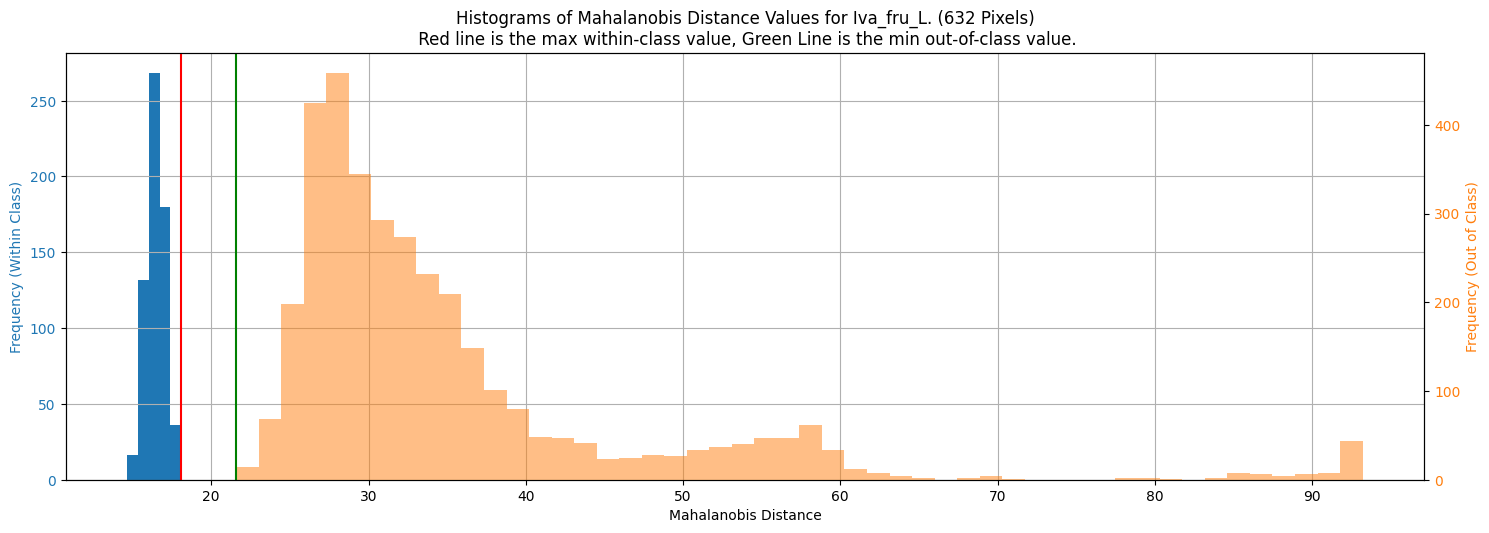

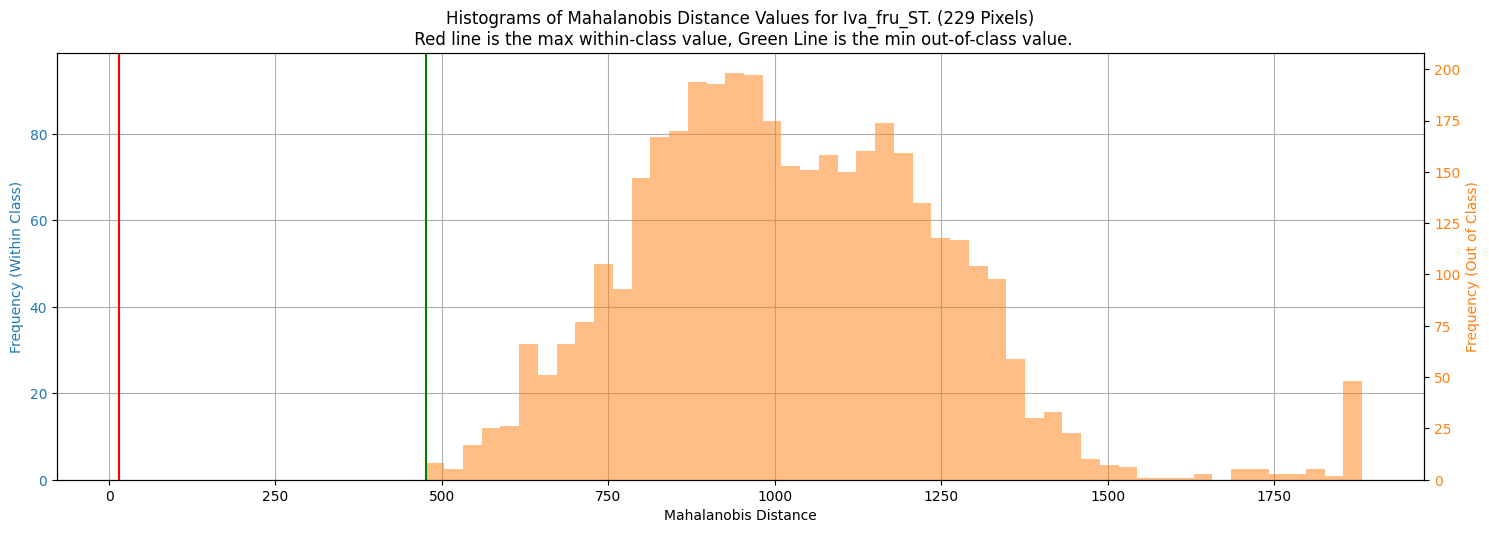

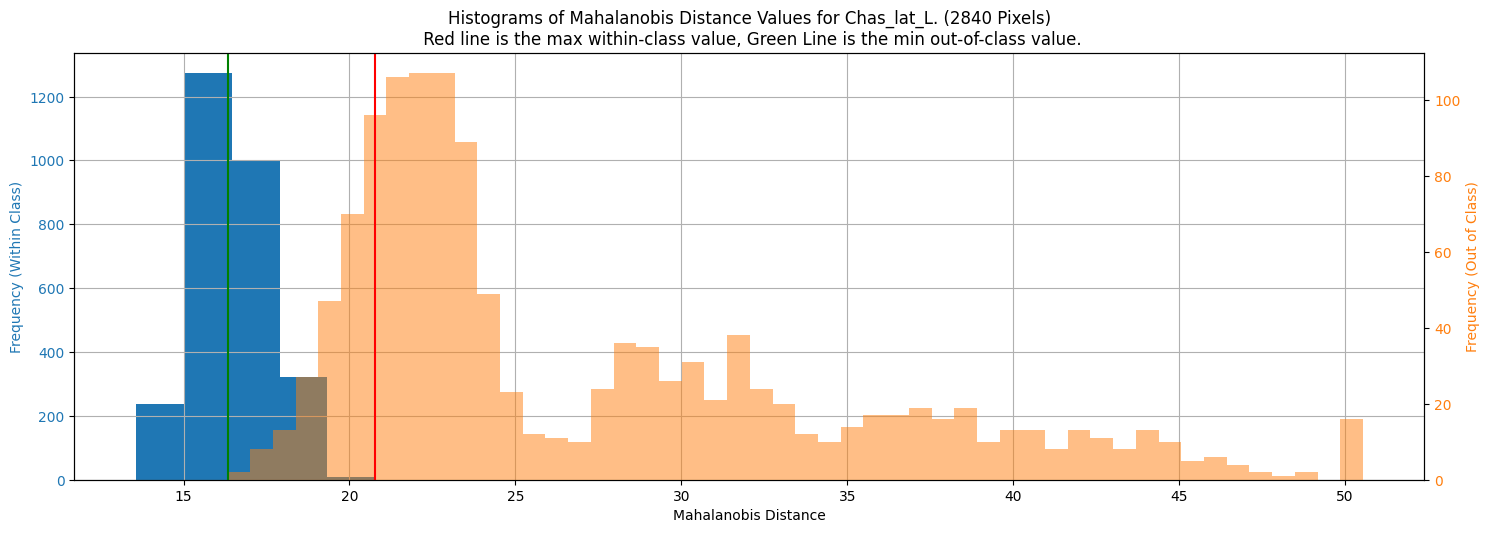

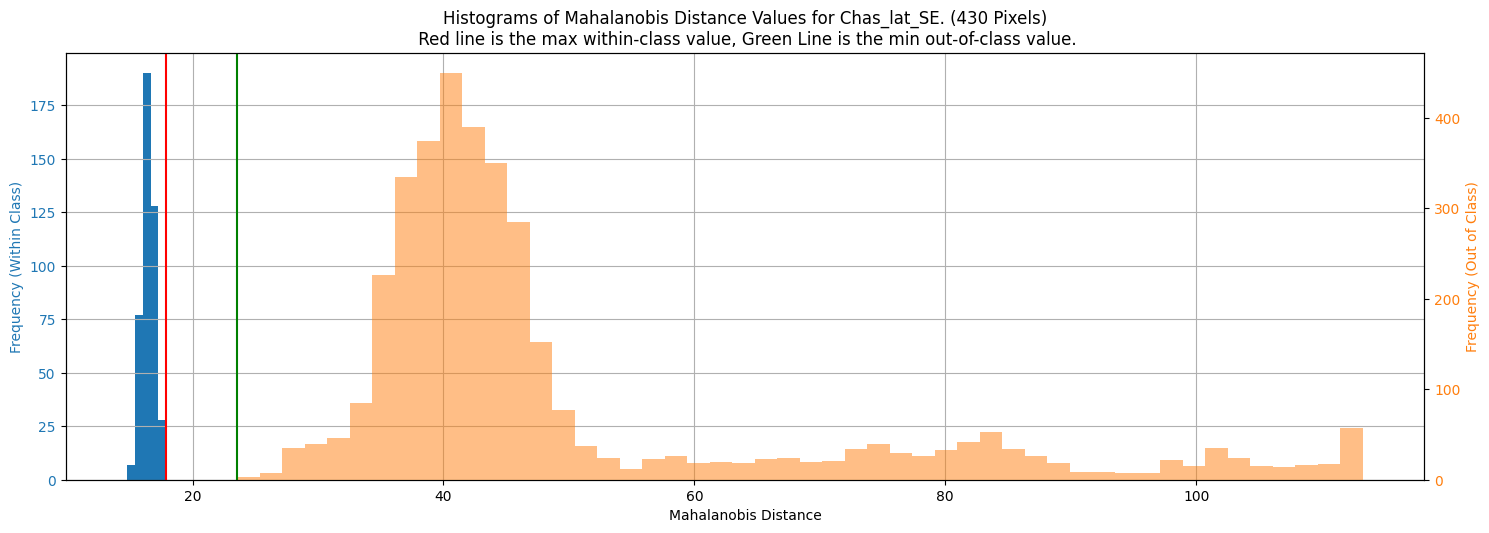

In [90]:
# Plot within-class and out-of-class histograms, giving each their own axis
for classIndex in range(nClasses):
    fig, ax1 = plt.subplots(figsize=(15,5))

    name = roi_names[classIndex]
    MD_this_class = MD[:,classIndex]
    MD_within_class = MD_this_class[spectra_names==name]
    MD_other_classes = MD_this_class[spectra_names!=name]
    MD_other_classes = np.clip(MD_other_classes, a_min=0, a_max=np.percentile(MD_other_classes, 99))  
    nSpectra_thei_class = np.sum(spectra_names==name)

    color = 'tab:blue'
    ax1.set_xlabel('Mahalanobis Distance')
    ax1.set_ylabel('Frequency (Within Class)', color=color)    
    bins = min(5, len(MD_within_class) // 10)
    if bins<5: 
        bins=5
    ax1.hist(MD_within_class, bins=bins);
    ax1.tick_params(axis='y', labelcolor=color)
    ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis
    
    color = 'tab:orange'
    ax2.set_ylabel('Frequency (Out of Class)', color=color)  # we already handled the x-label with ax1  
    bins = min(50, len(MD_other_classes) // 5)
    ax2.hist(MD_other_classes, bins=bins, color=color, alpha=0.5);
    ax2.tick_params(axis='y', labelcolor=color)
    
    plt.axvline(np.max(MD_within_class), color='r')    
    plt.axvline(np.min(MD_other_classes), color='g')

    ax1.grid(True)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.title(f'Histograms of Mahalanobis Distance Values for {name}. ({nSpectra_thei_class} Pixels)\n Red line is the max within-class value, Green Line is the min out-of-class value.');
    plt.show()

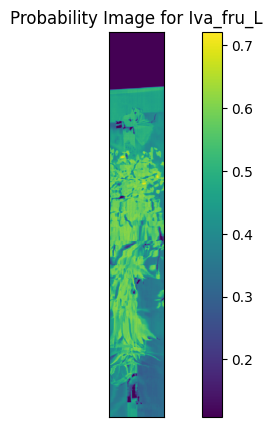

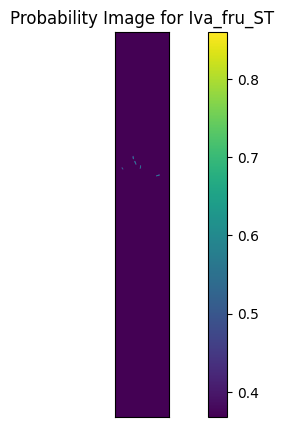

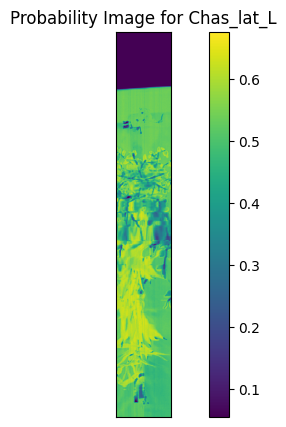

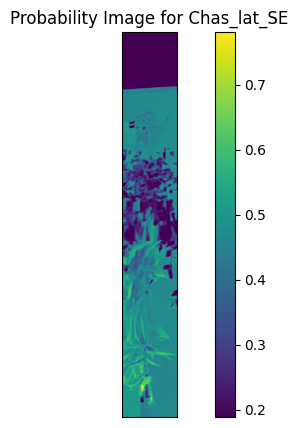

In [97]:
nClasses = len(roi_names)
nb = spectra.shape[1]
C = np.zeros((nb,nb)) # covariance (Sigma in the Wikipedia page)
for name in roi_names:
    # get the spectra for this class
    class_spectra = spectra[spectra_names==name,:]    
    # compute the covariance for this class
    C_class = np.cov(class_spectra.T)
    # compute the number of spectra in this class
    nSpec_class = class_spectra.shape[0]
    # add the covariance of this class,
    # weighted by the fraction of total pixels that come from this class
    C = C + (nSpec_class/nSpec)*C_class 

# compute the whitening matrix
evals,evecs = np.linalg.eigh(C)
tol = 10**(-6)
evals[evals<tol] = tol
DiagMatrix = np.diag(evals**(-1/2))
roi_Ws[name] = np.matmul(evecs,DiagMatrix)
DiagMatrix = np.diag(evals**(-1/2))
W_all = np.matmul(evecs,DiagMatrix)
    
# Create array to hold the Mahalanobis Distance
MD = np.zeros((nSpec, nClasses))

# compute the mean and covariance for each class
roi_means = {}
roi_Ws = {}
for name in roi_names:
    plt.figure(figsize=(10,5))
    # get the spectra for this class
    class_spectra = spectra[spectra_names==name,:] 
    # compute the covariance for this class
    mu = np.mean(class_spectra, axis=0)
    C = np.cov(class_spectra.T)
    # Compute the eigenvectors, eigenvalues, and whitening matrix
    evals,evecs = np.linalg.eigh(C)
    # truncate the small eigenvalues to stablize the inverse
    tol = 10**(-8)
    evals[evals<tol] = tol
    DiagMatrix = np.diag(evals**(-1/2))
    roi_Ws[name] = np.matmul(evecs,DiagMatrix)
    DiagMatrix = np.diag(evals**(-1/2))
    W_this_class = np.matmul(evecs,DiagMatrix)
    
    if np.sum(spectra_names==name) < 100:
        W = W_all
    else:
        W = W_this_class        
    
    MD_class = np.sqrt(np.sum((np.matmul(W.T, (im.List - mu).T).T)**2, axis=1))
    MD_class[MD_class>100] = 100
    MD_class = MD_class/np.mean(MD_class)
    MD_class = np.real(MD_class)
    #MD_class = MD_class - np.min(MD_class)
    MD_class_im = np.reshape(MD_class, (nr,nc))
    plt.imshow(np.exp(-MD_class_im))
    plt.xticks([])
    plt.yticks([])
    plt.title(f'Probability Image for {name}')
    plt.colorbar()

## Evaluation Metrics

In [ ]:
from sklearn.metrics import classification_report

y_true = gt_list[np.where(gt_list>0)[0]]
LDA_class_list = np.argmin(MD_all, axis=1)
y_pred = LDA_class_list[np.where(gt_list>0)[0]]


# modifying for scoring
y_true = y_true - 1
y_true = (y_true).astype(int)

cr = classification_report(y_true, y_pred, target_names=class_names)

print(cr)

In [98]:
MD_all[2000,:]**(-1)

NameError: name 'MD_all' is not defined

# Step 6: Load spectral libraries from multiple microscene collects.

# Step 7: Build, train, test and save classification\detection models from these multi-collect libraries.

# Step 8: Apply these models to Microscene images and rigorously evaluate accuracy.

# Step 9: Apply these models to UAS hyperspectral images and rigorously evaluate accuracy.